In [1]:
import matplotlib.pyplot as plt
from itertools import combinations
from random import random,randint
import numpy as np
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm

import time
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import picos as pic
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
import scipy.linalg as la
from itertools import permutations, combinations


In [2]:
def num_1_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_1 = get_indexes(1,d)
    return num_1,len(num_1)

def num_0_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_0 = get_indexes(0,d)
    return num_0,len(num_0)

def column(matrix, i):
    return [row[i] for row in matrix]

#Construct initial state 
def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

def bin2dec(string_num):
    return str(int(string_num, 2))

def row_binary(v):
    for i in range(len(v)):
        if v[i]%2 == 0:
            v[i] = 0
        else:
            v[i] = 1 
    return v

def converter(d):
    P = 0
    for i in range(len(d)):
        P+=d[i]*(2**(len(d)-i-1))
    return P
                 
#Define some pauli operators
PauliX = [[0,1],[1,0]]   
PauliZ = [[1,0],[0,-1]]
PauliI = np.eye(2)

#Define Cjk and B
def Cjk_generator(d):
    n = len(d)
    l = list(range(0,n))    
    for i in range(n):
        l[i] = PauliI
    s = num_1_pos(d)[0]
    for j in range(len(s)):
        l[s[j]] = PauliZ
    Cjk = l[0]
    for i in range(n-1):
        Cjk = np.kron(Cjk,l[i+1])
    return Cjk

def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = sum(b[a] for a in range(n))
    return B

def basis(n):
    nums = np.array([a for a in range(2**(n))]) 
    bin_nums = (((nums.reshape(-1,1) & (2**np.arange(n)))) != 0).astype(int)
    a = bin_nums[:,::-1]
    return a


def matrix_binary(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i][j]%2 == 0:
                A[i][j] = 0
            else:
                A[i][j] = 1
    return A

def z_gen(syndr,H):
    z = []
    for w in range((H.shape[1]-len(syndr))):
        z.append(0)
    for a in range(len(syndr)):
        z.append(syndr[a])
    return z


In [7]:
G_oringin = np.array([[1,0,0,0,1,0,1,0,1],
              [0,1,0,0,1,0,0,1,1],
              [0,0,1,0,0,1,1,0,1],
              [0,0,0,1,0,1,0,1,1]])
G_oringinT = G_oringin.T
H = np.array([[1,1,0,0,1,0,0,0,0],
                      [0,0,1,1,0,1,0,0,0],
                      [1,0,1,0,0,0,1,0,0],
                      [0,1,0,1,0,0,0,1,0],
                      [1,1,1,1,0,0,0,0,1]])
HT = H.T

# Syndrome

In [8]:
syndr = HT[0]
print(syndr)

[1 0 1 0 1]


# Oringinal with one bit error

syndrome: [1 0 1 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


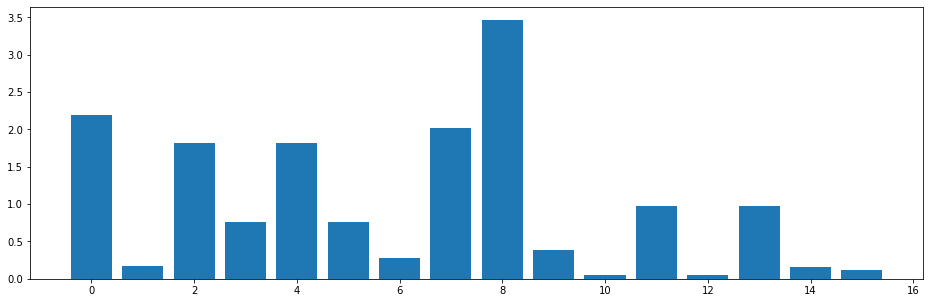

syndrome: [1 0 1 0 1]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


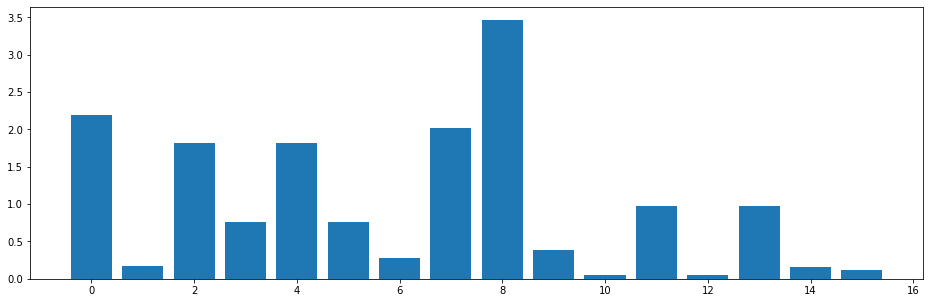

syndrome: [1 0 1 0 1]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


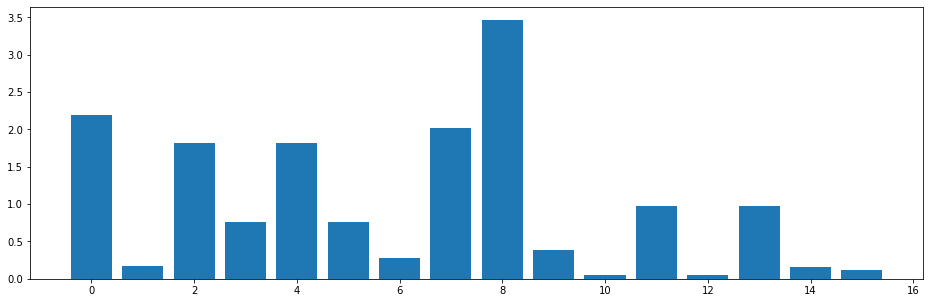

syndrome: [1 0 1 0 1]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


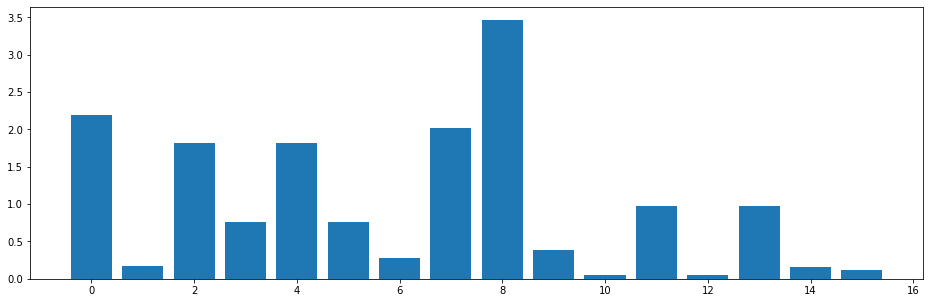

syndrome: [1 0 1 0 1]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


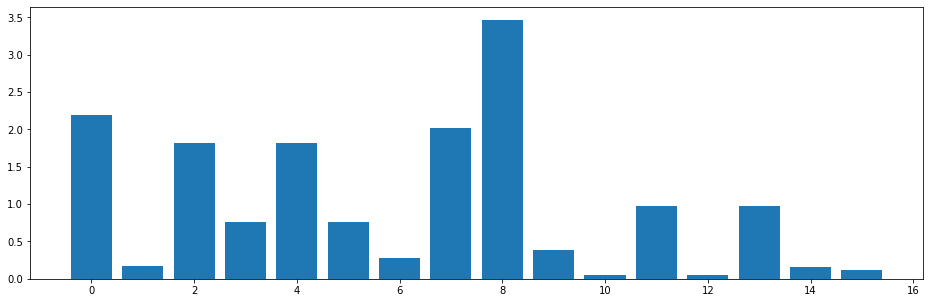

syndrome: [1 0 1 0 1]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


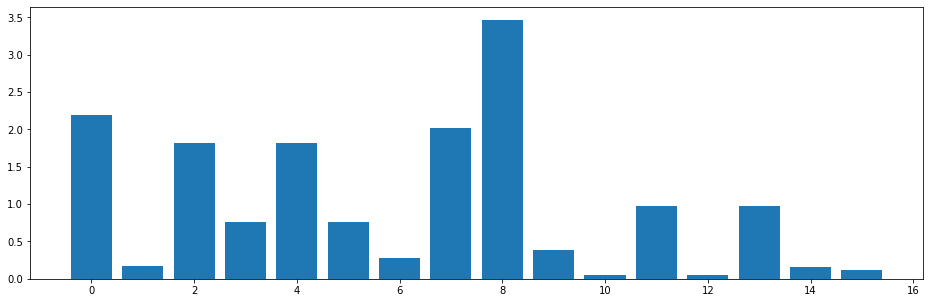

syndrome: [1 0 1 0 1]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


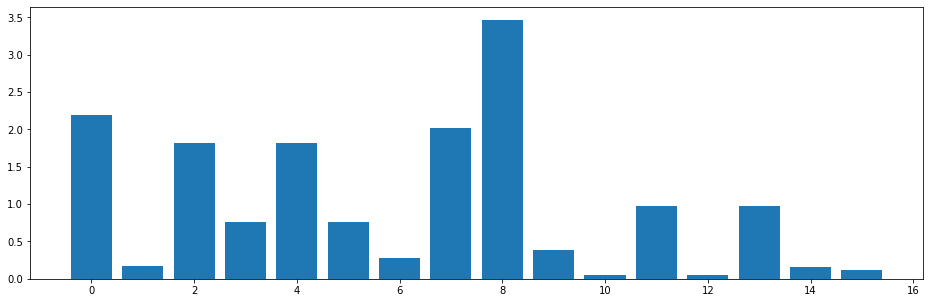

syndrome: [1 0 1 0 1]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


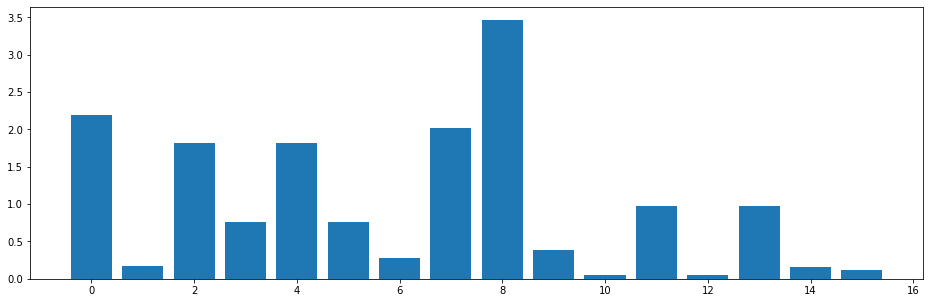

syndrome: [1 0 1 0 1]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


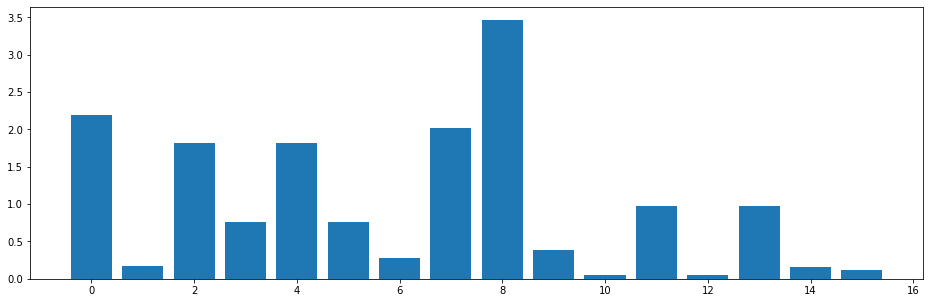

syndrome: [1 0 1 0 1]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


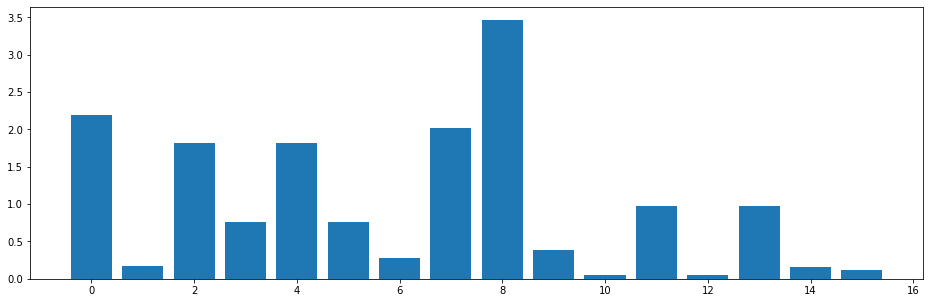

syndrome: [1 0 1 0 1]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


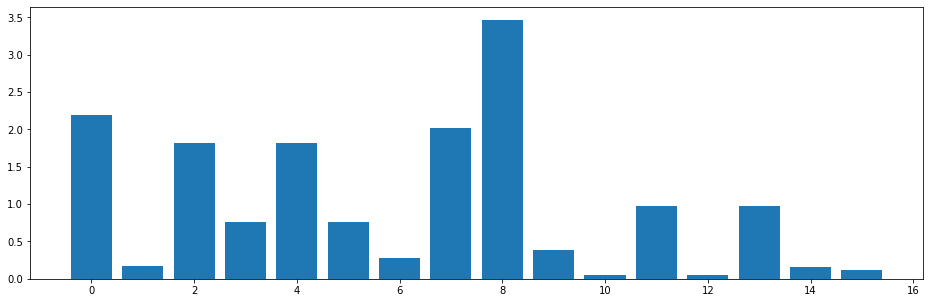

syndrome: [1 0 1 0 1]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


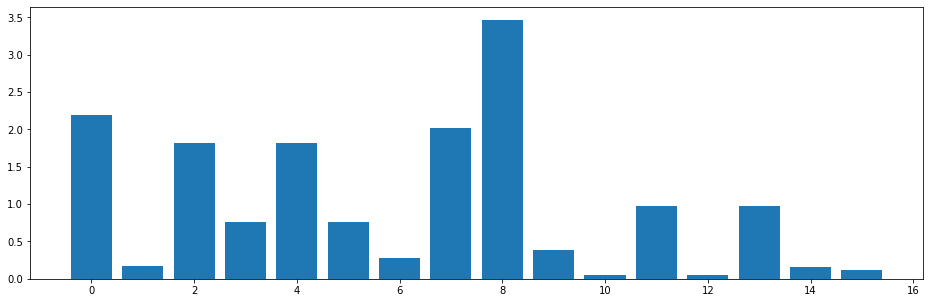

syndrome: [1 0 1 0 1]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


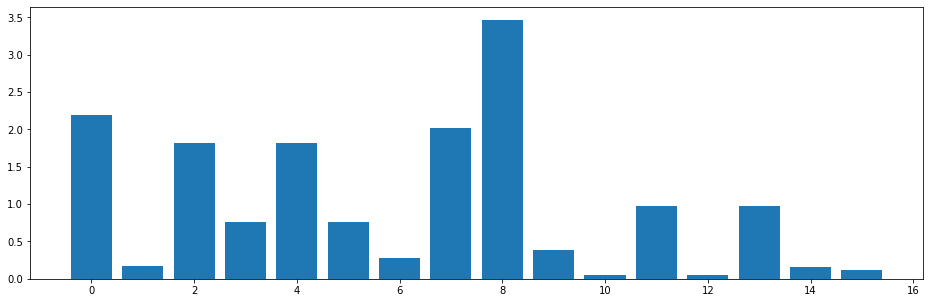

syndrome: [1 0 1 0 1]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


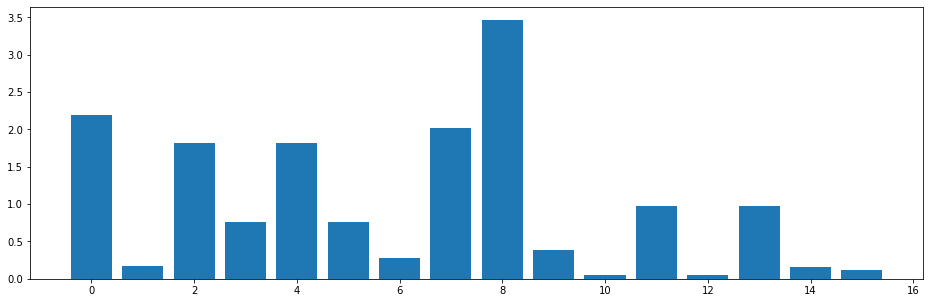

syndrome: [1 0 1 0 1]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


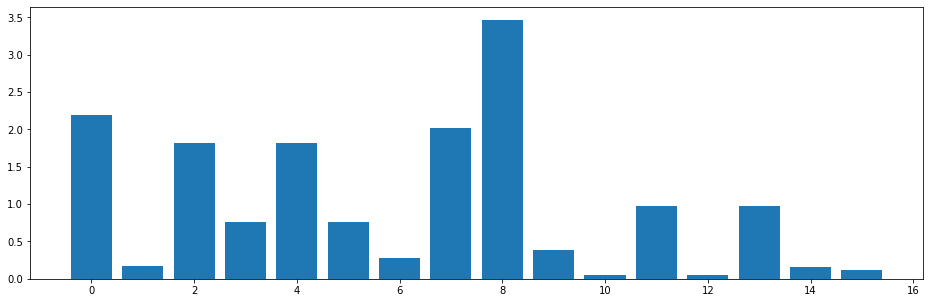

syndrome: [1 0 1 0 1]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 1, 0, 1, 0, 1]
most likey basis:   8
estimate message: [1 0 0 0]
error: [1 0 0 0 0 0 0 0 0]


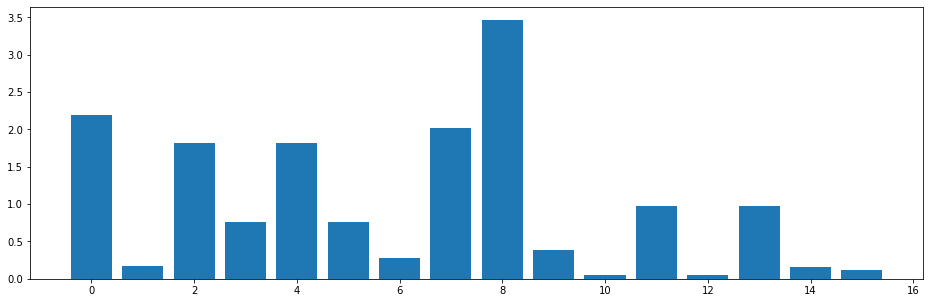

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


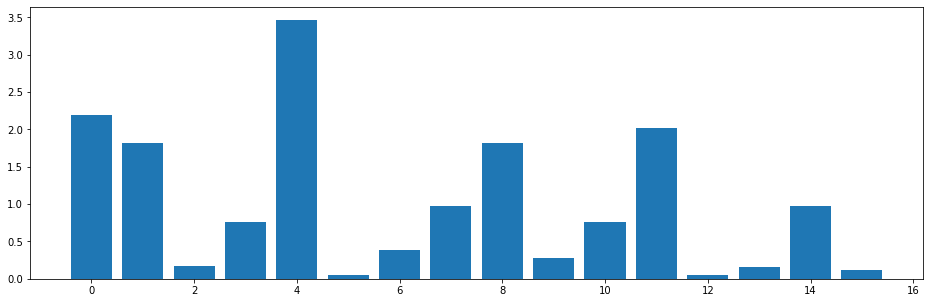

syndrome: [1 0 0 1 1]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


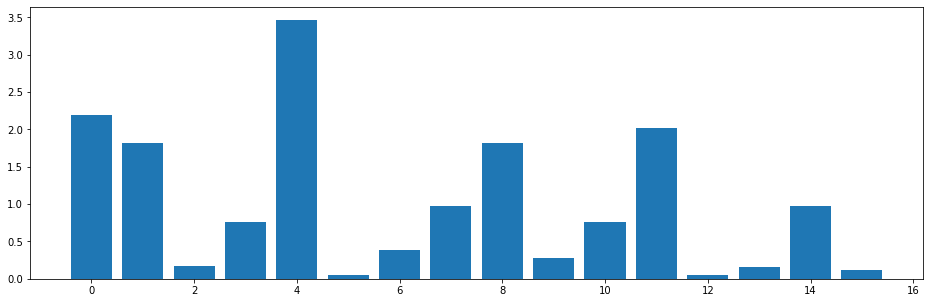

syndrome: [1 0 0 1 1]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


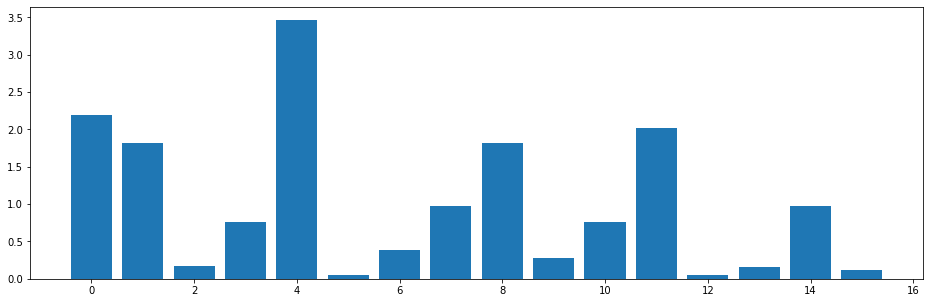

syndrome: [1 0 0 1 1]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


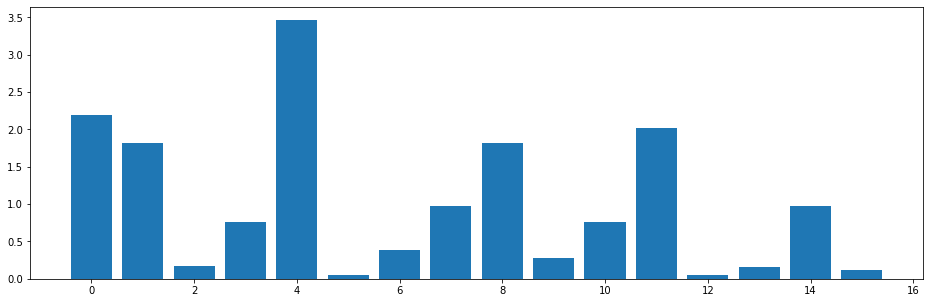

syndrome: [1 0 0 1 1]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


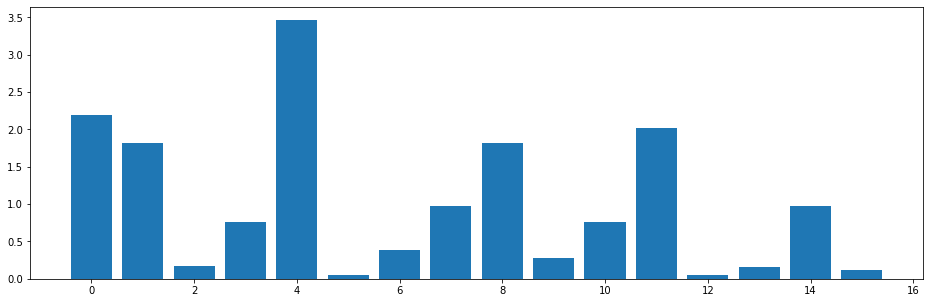

syndrome: [1 0 0 1 1]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


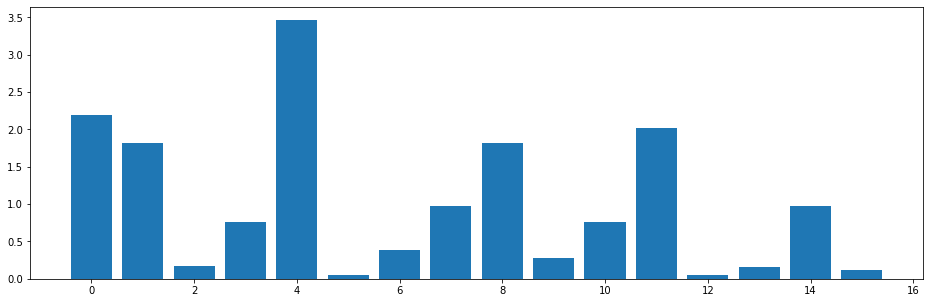

syndrome: [1 0 0 1 1]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


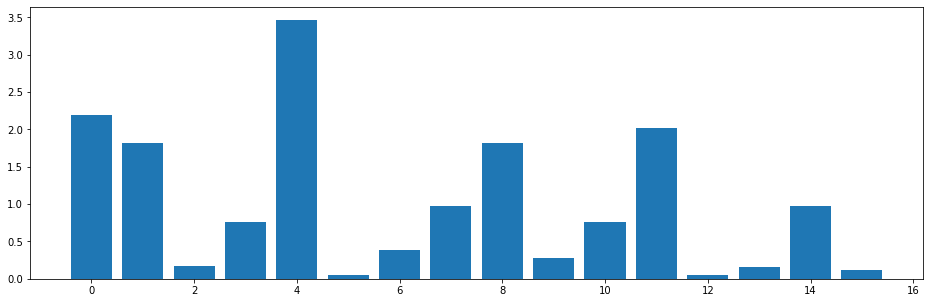

syndrome: [1 0 0 1 1]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


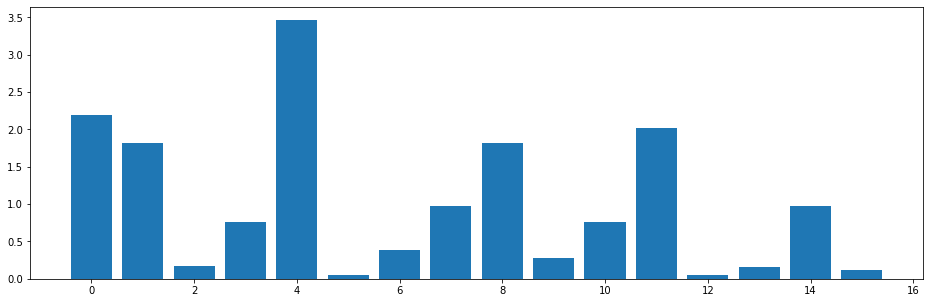

syndrome: [1 0 0 1 1]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


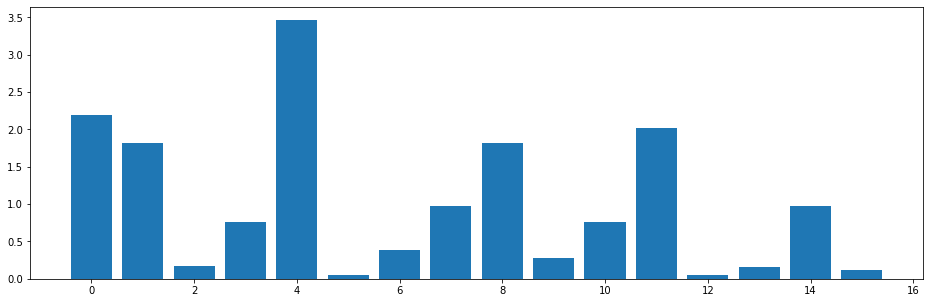

syndrome: [1 0 0 1 1]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


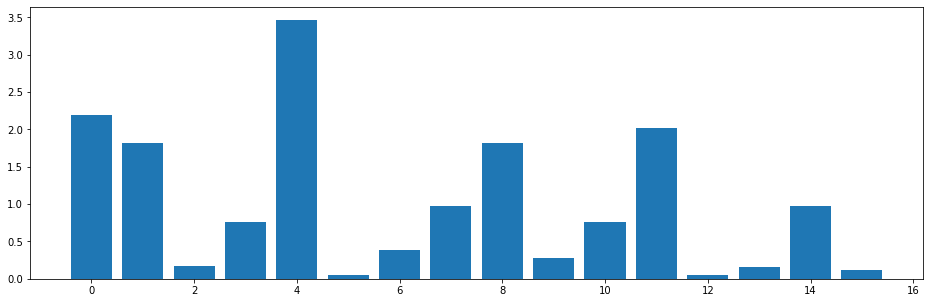

syndrome: [1 0 0 1 1]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


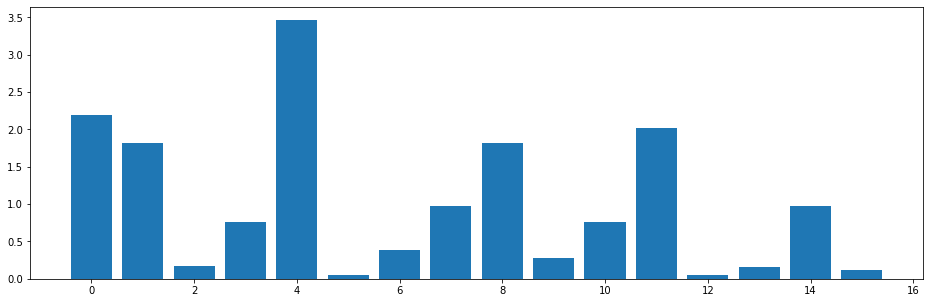

syndrome: [1 0 0 1 1]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


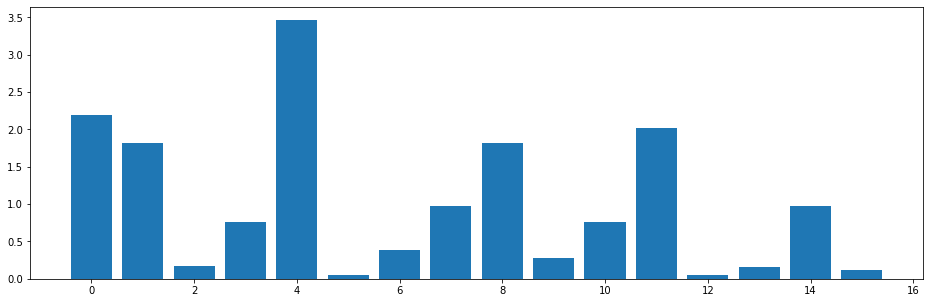

syndrome: [1 0 0 1 1]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


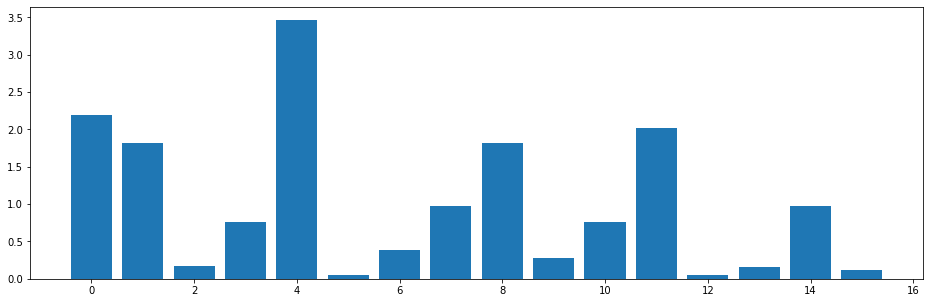

syndrome: [1 0 0 1 1]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


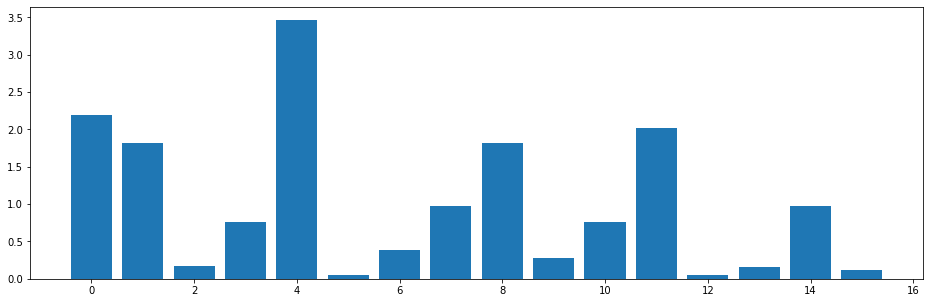

syndrome: [1 0 0 1 1]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


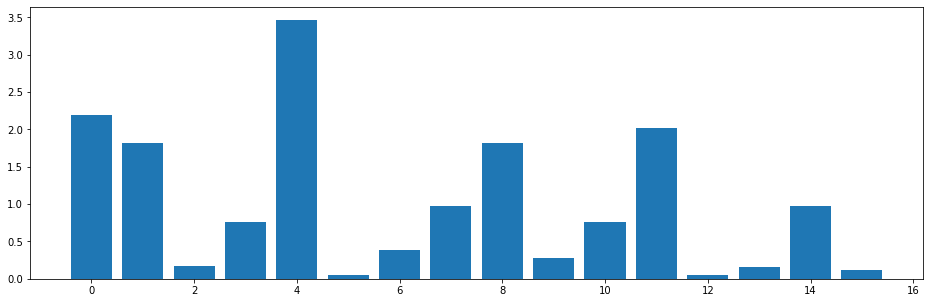

syndrome: [1 0 0 1 1]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 1, 1]
most likey basis:   4
estimate message: [0 1 0 0]
error: [0 1 0 0 0 0 0 0 0]


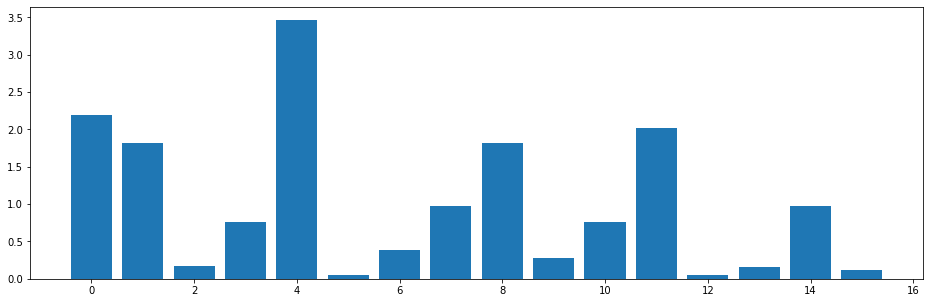

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


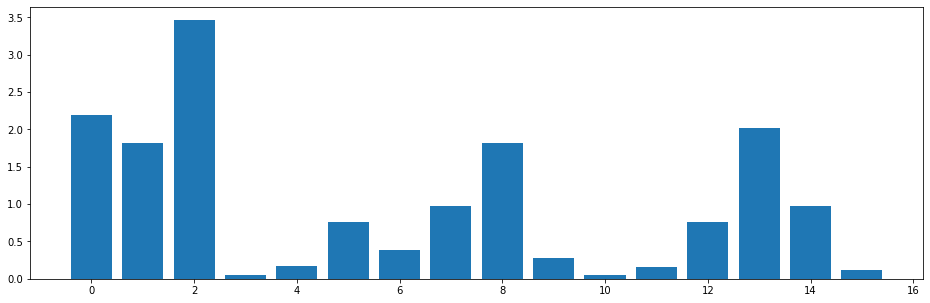

syndrome: [0 1 1 0 1]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


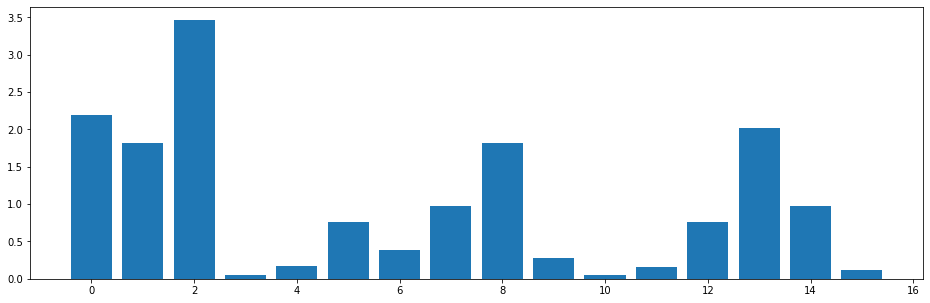

syndrome: [0 1 1 0 1]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


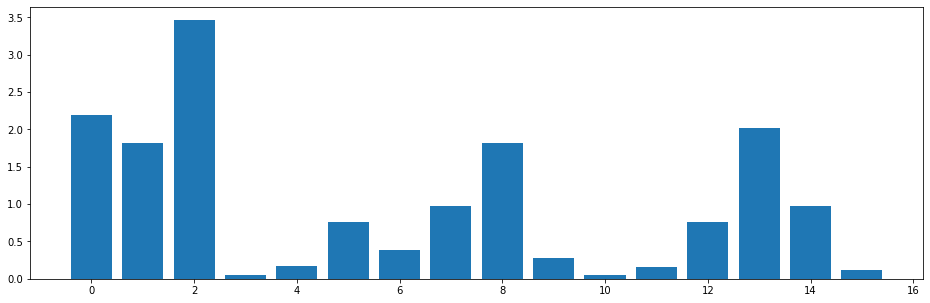

syndrome: [0 1 1 0 1]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


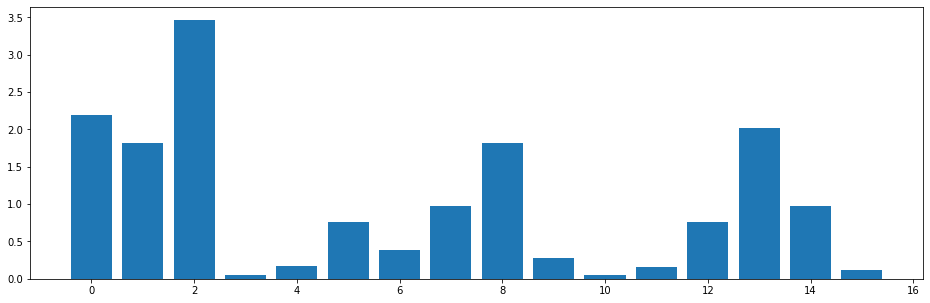

syndrome: [0 1 1 0 1]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


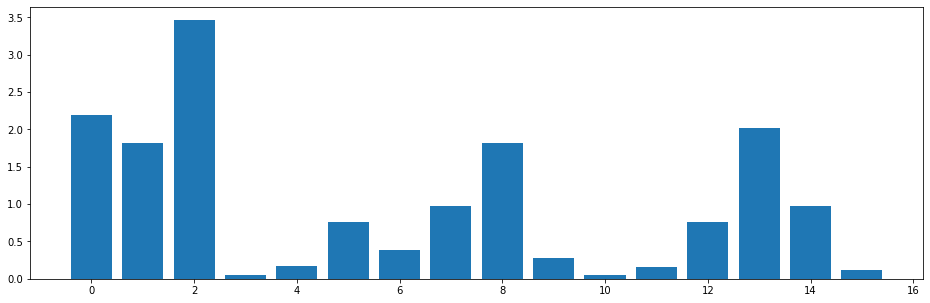

syndrome: [0 1 1 0 1]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


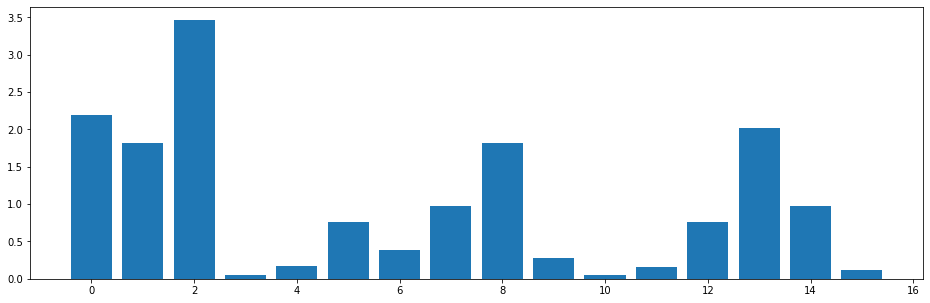

syndrome: [0 1 1 0 1]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


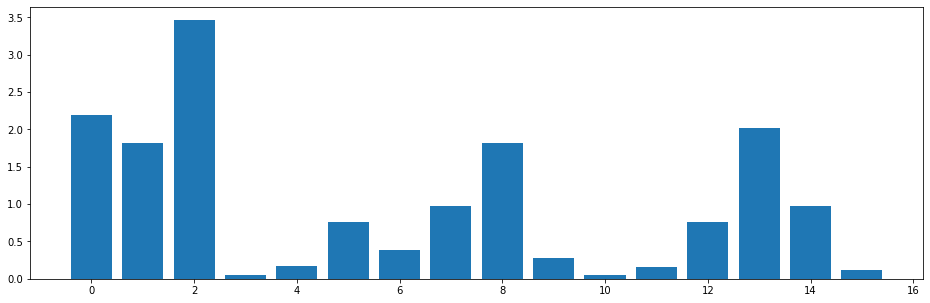

syndrome: [0 1 1 0 1]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


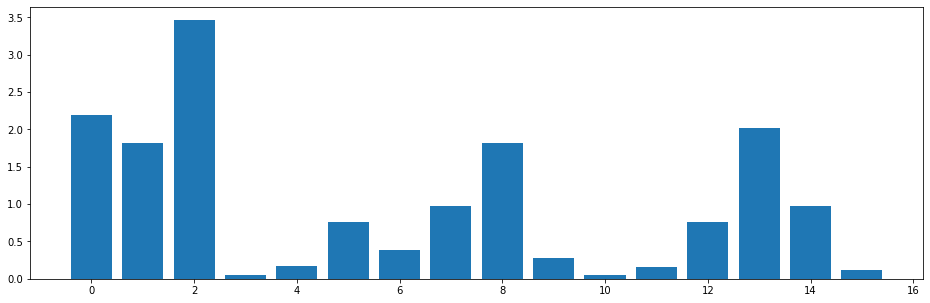

syndrome: [0 1 1 0 1]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


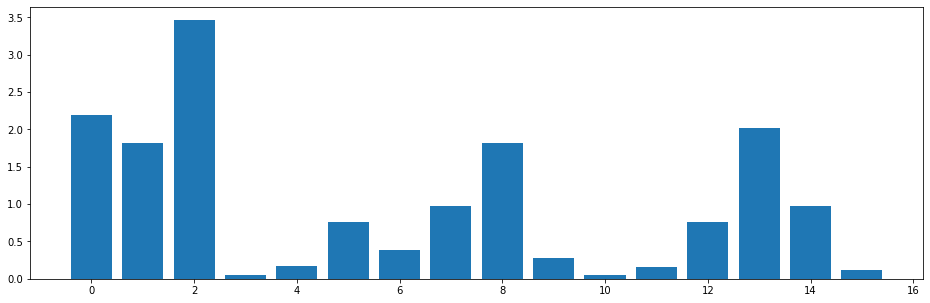

syndrome: [0 1 1 0 1]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


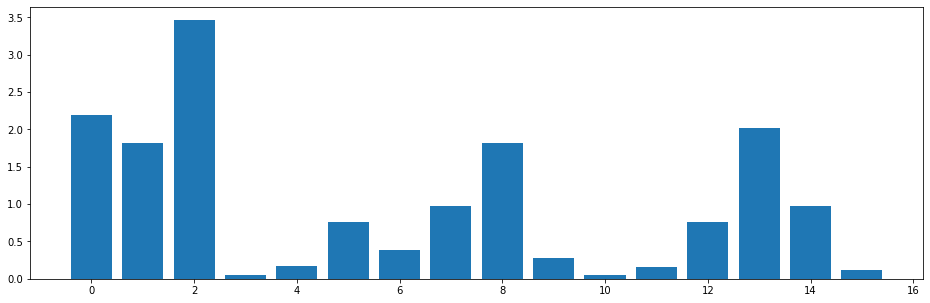

syndrome: [0 1 1 0 1]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


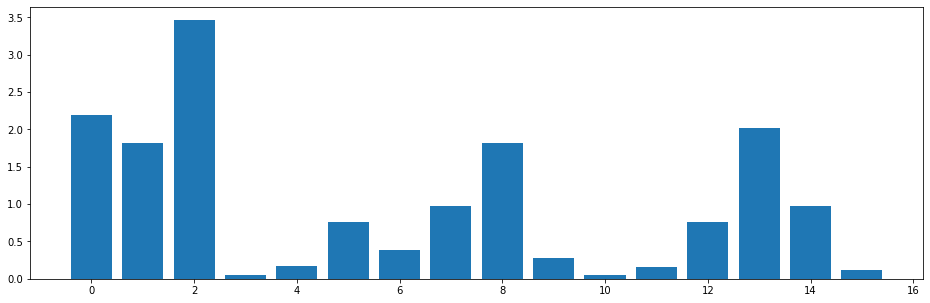

syndrome: [0 1 1 0 1]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


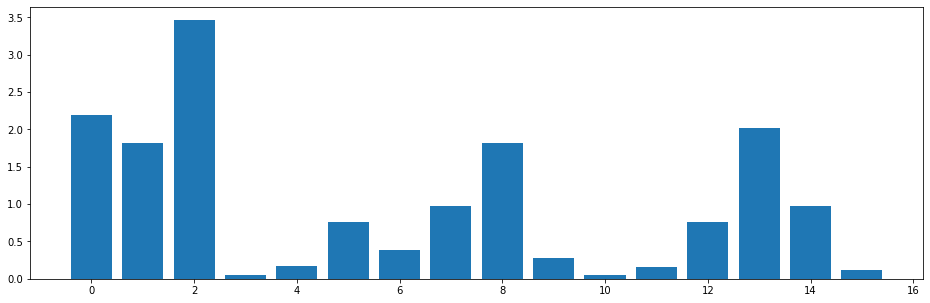

syndrome: [0 1 1 0 1]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


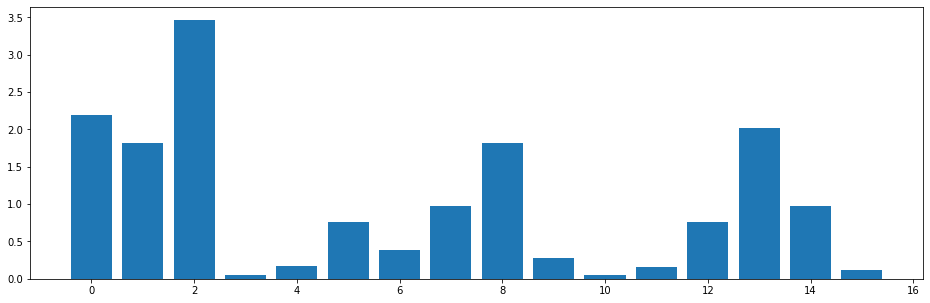

syndrome: [0 1 1 0 1]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


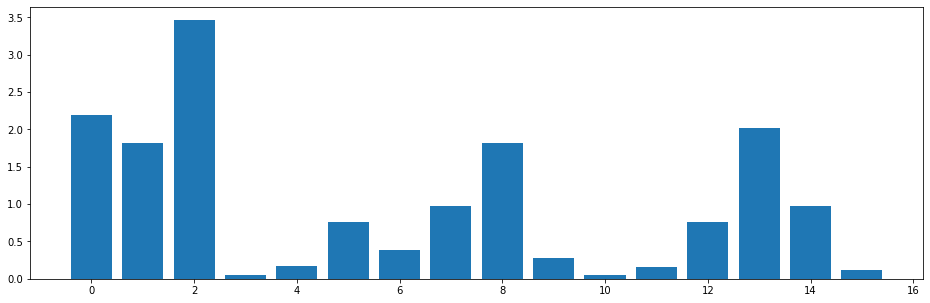

syndrome: [0 1 1 0 1]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


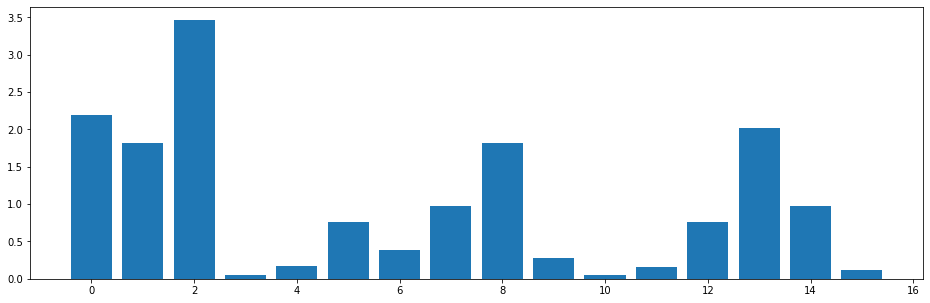

syndrome: [0 1 1 0 1]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 0, 1, 1, 0, 1]
most likey basis:   2
estimate message: [0 0 1 0]
error: [0 0 1 0 0 0 0 0 0]


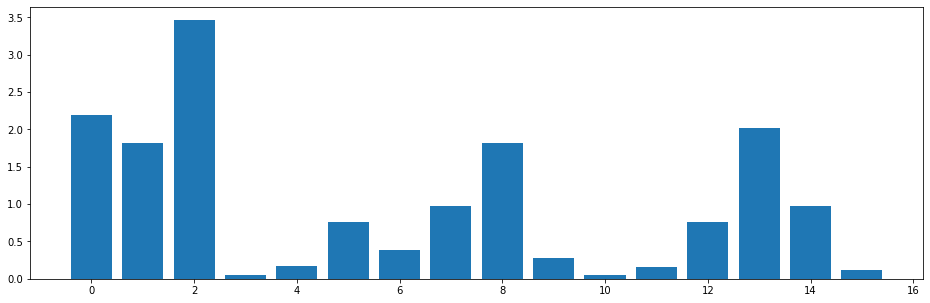

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0 1 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


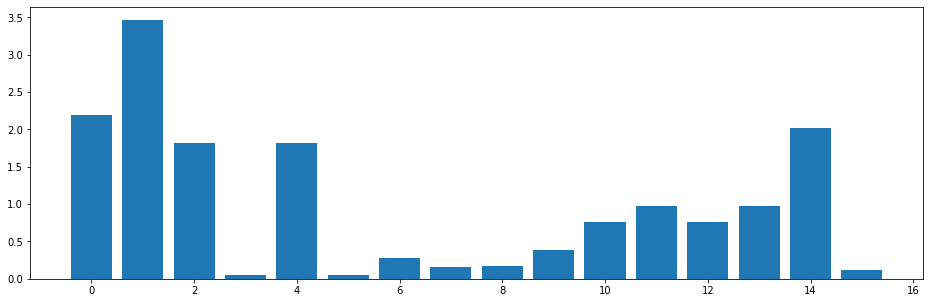

syndrome: [0 1 0 1 1]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


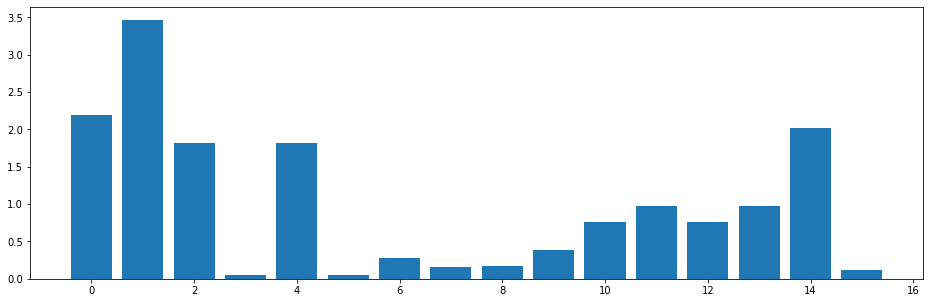

syndrome: [0 1 0 1 1]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


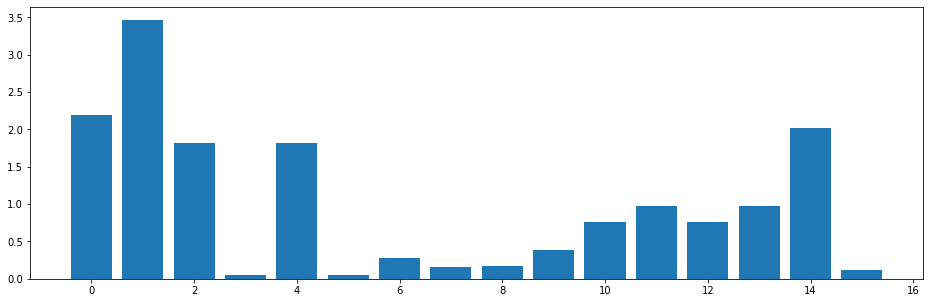

syndrome: [0 1 0 1 1]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


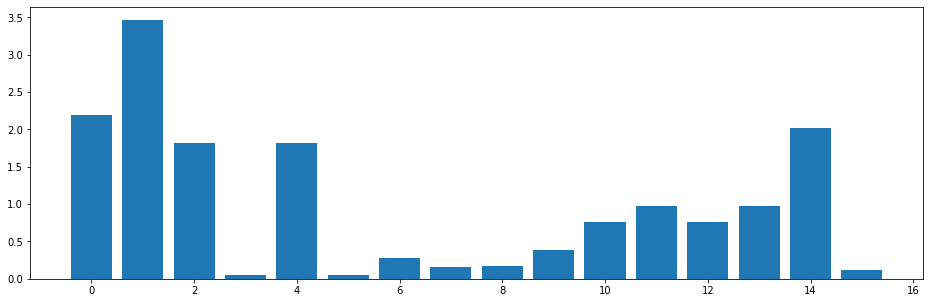

syndrome: [0 1 0 1 1]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


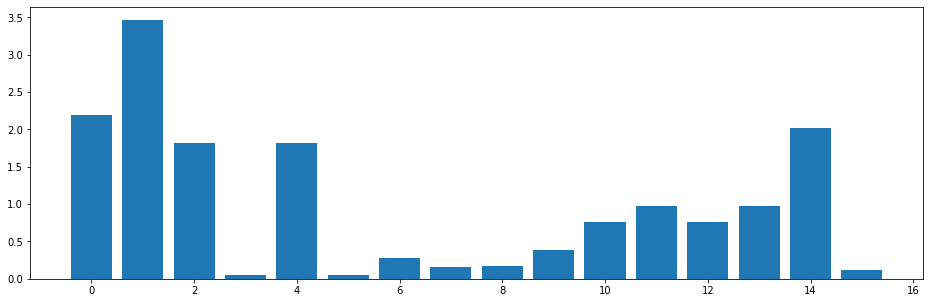

syndrome: [0 1 0 1 1]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


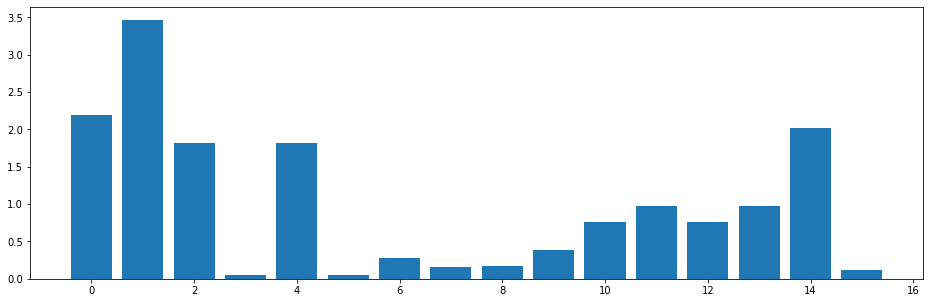

syndrome: [0 1 0 1 1]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


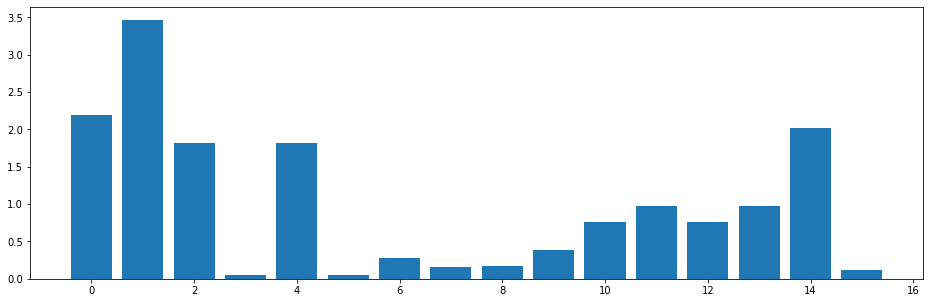

syndrome: [0 1 0 1 1]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


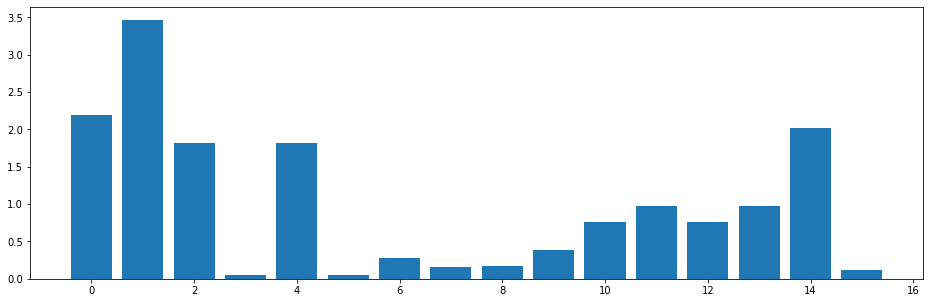

syndrome: [0 1 0 1 1]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


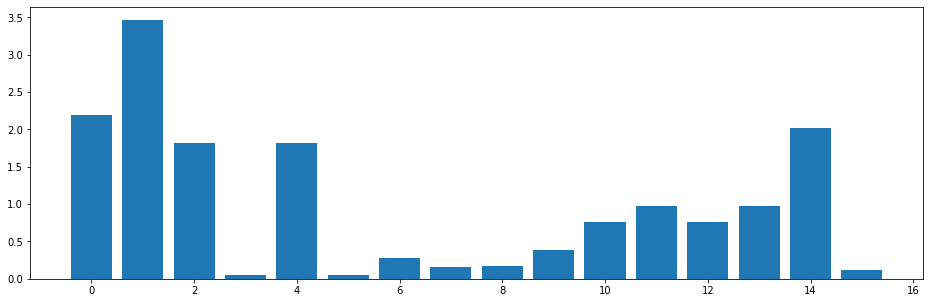

syndrome: [0 1 0 1 1]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


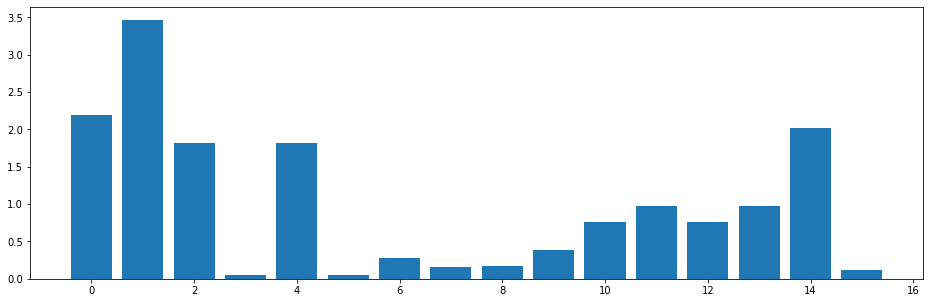

syndrome: [0 1 0 1 1]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


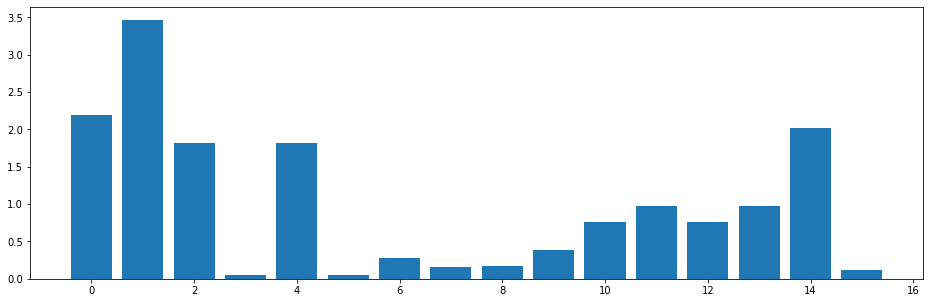

syndrome: [0 1 0 1 1]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


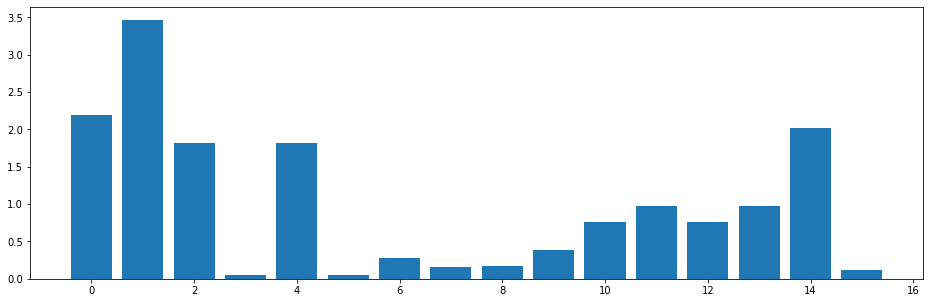

syndrome: [0 1 0 1 1]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


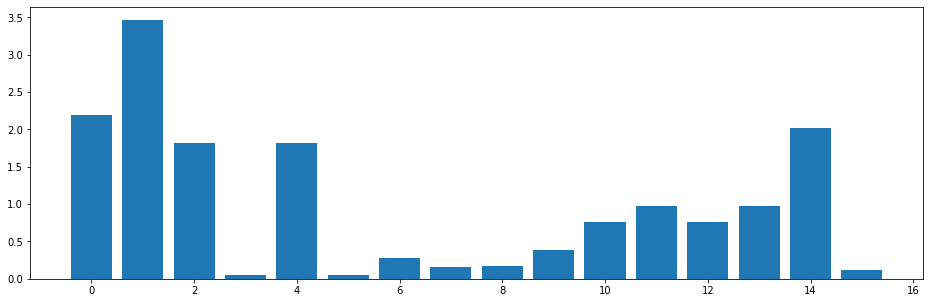

syndrome: [0 1 0 1 1]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


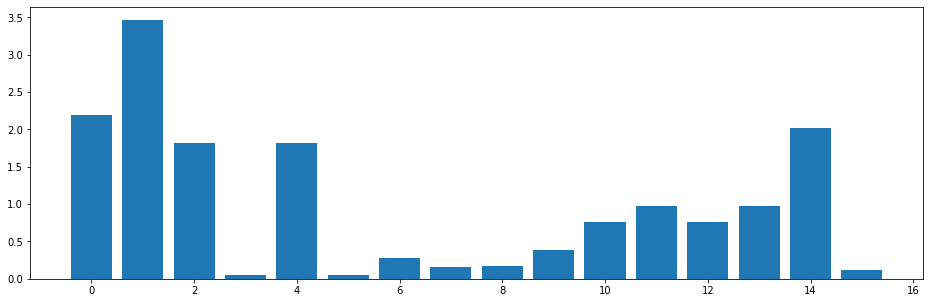

syndrome: [0 1 0 1 1]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


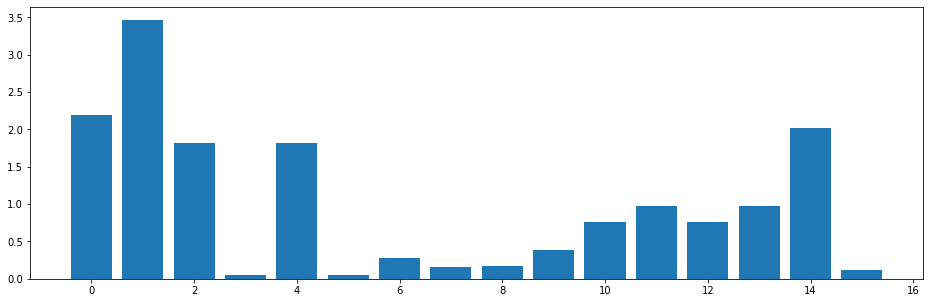

syndrome: [0 1 0 1 1]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 1, 1]
most likey basis:   1
estimate message: [0 0 0 1]
error: [0 0 0 1 0 0 0 0 0]


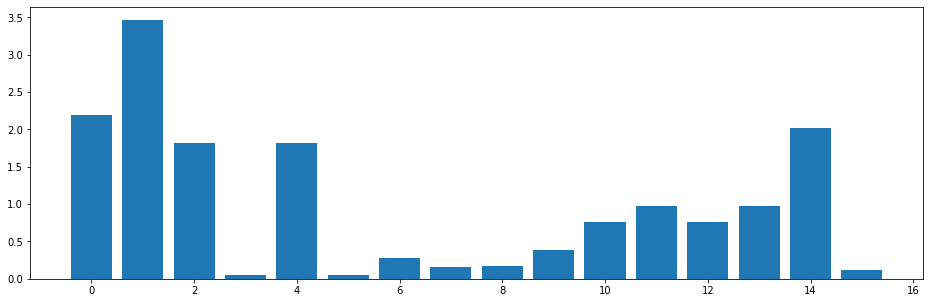

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0 0 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


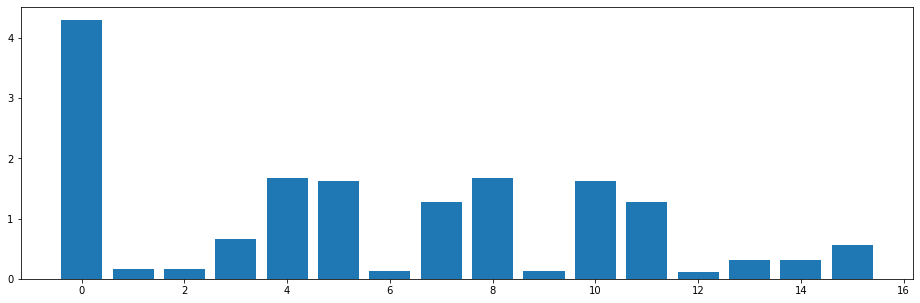

syndrome: [1 0 0 0 0]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


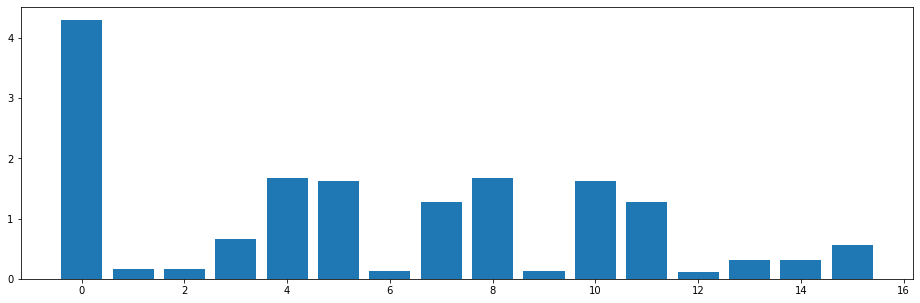

syndrome: [1 0 0 0 0]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


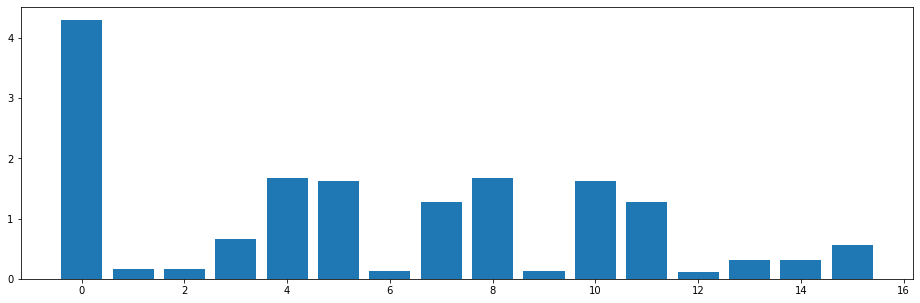

syndrome: [1 0 0 0 0]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


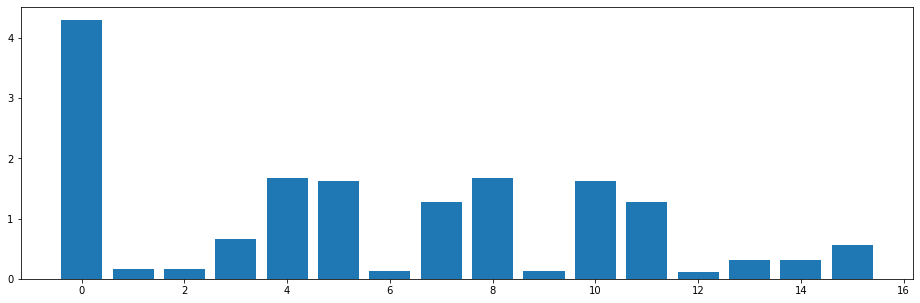

syndrome: [1 0 0 0 0]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


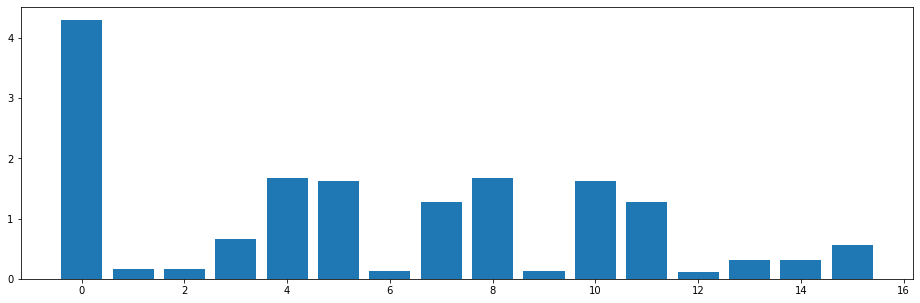

syndrome: [1 0 0 0 0]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


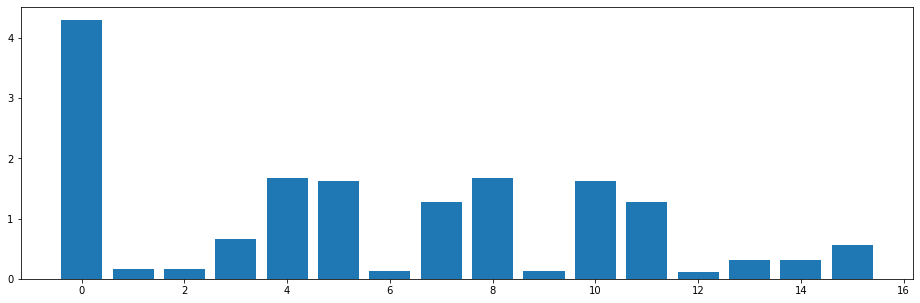

syndrome: [1 0 0 0 0]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


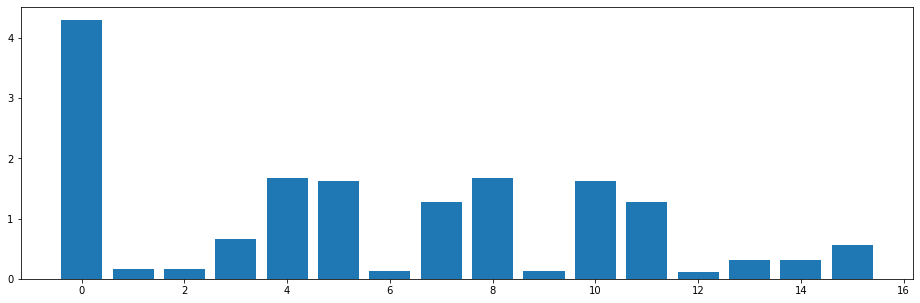

syndrome: [1 0 0 0 0]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


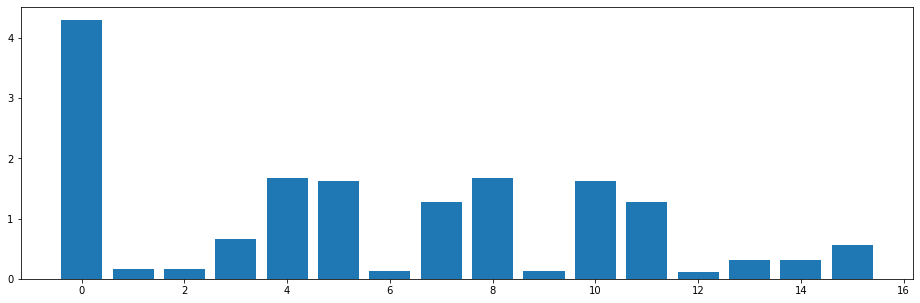

syndrome: [1 0 0 0 0]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


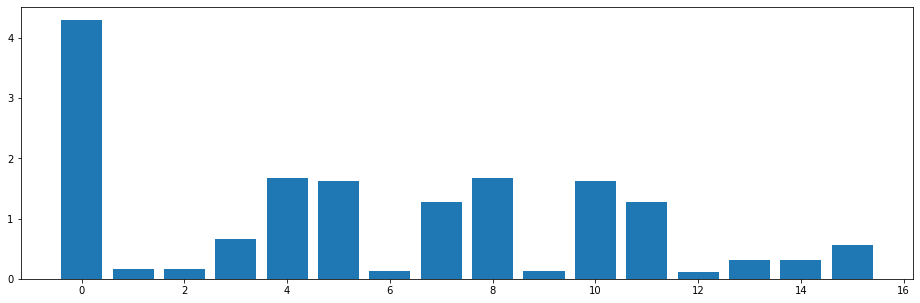

syndrome: [1 0 0 0 0]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


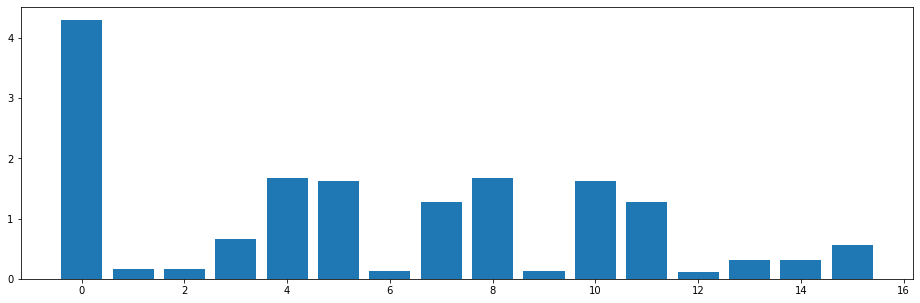

syndrome: [1 0 0 0 0]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


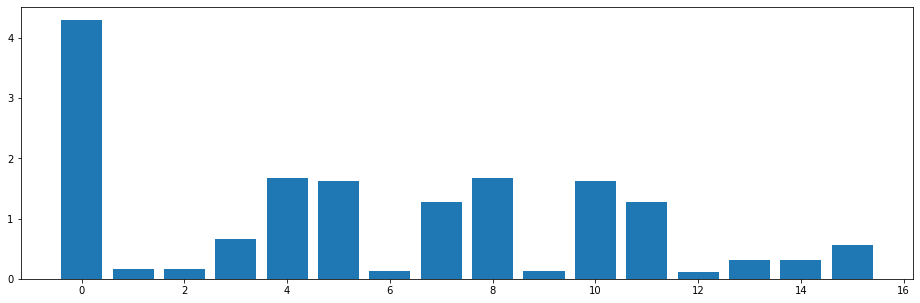

syndrome: [1 0 0 0 0]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


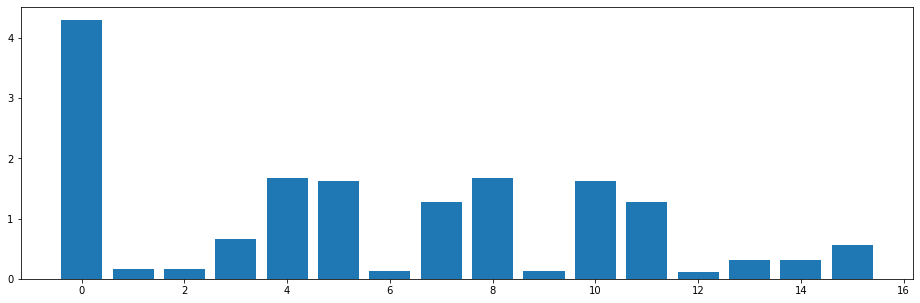

syndrome: [1 0 0 0 0]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


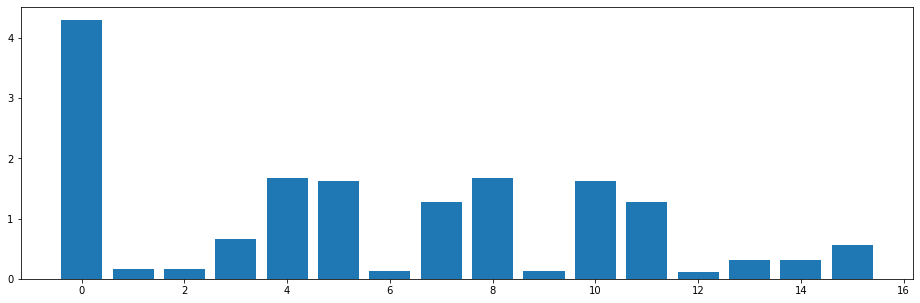

syndrome: [1 0 0 0 0]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


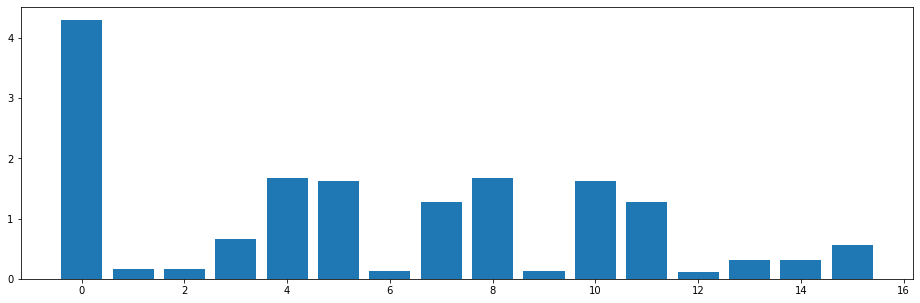

syndrome: [1 0 0 0 0]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


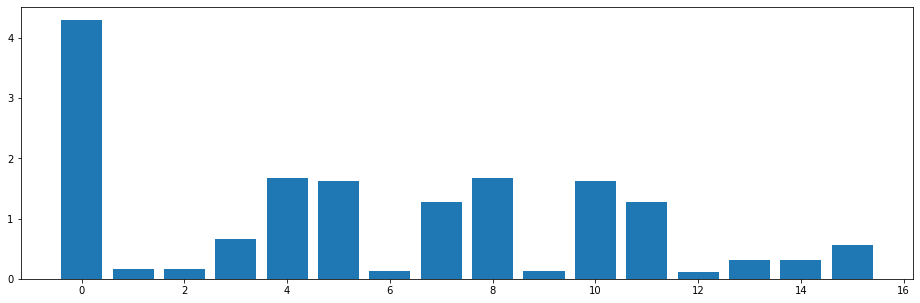

syndrome: [1 0 0 0 0]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 1, 0, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 1 0 0 0 0]


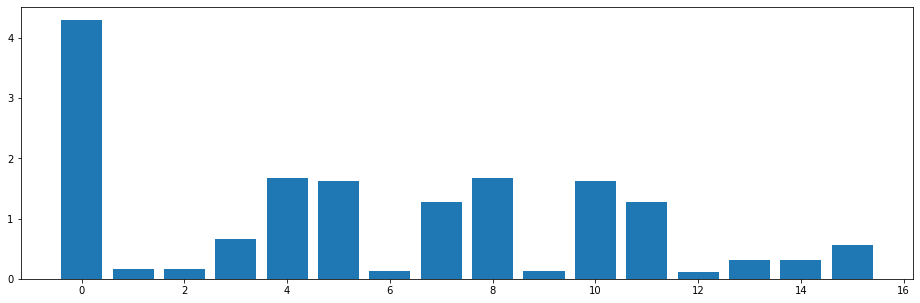

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0 0 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


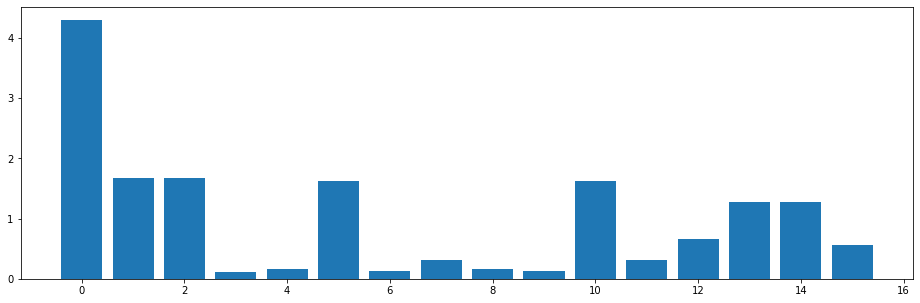

syndrome: [0 1 0 0 0]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


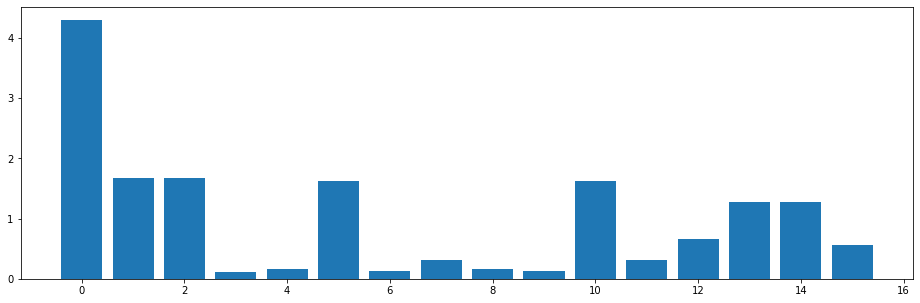

syndrome: [0 1 0 0 0]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


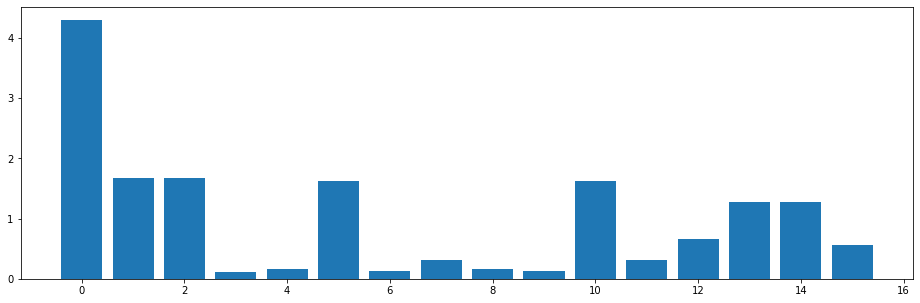

syndrome: [0 1 0 0 0]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


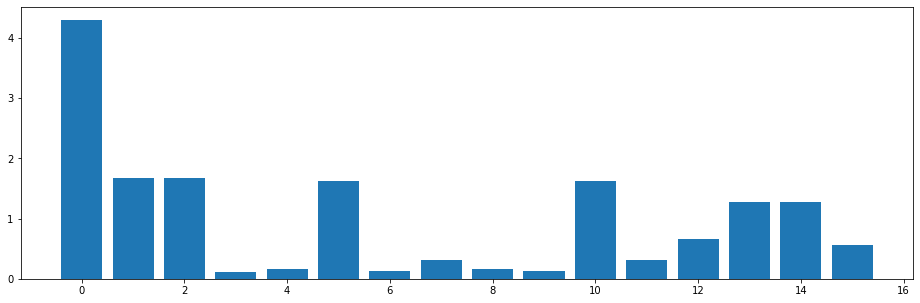

syndrome: [0 1 0 0 0]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


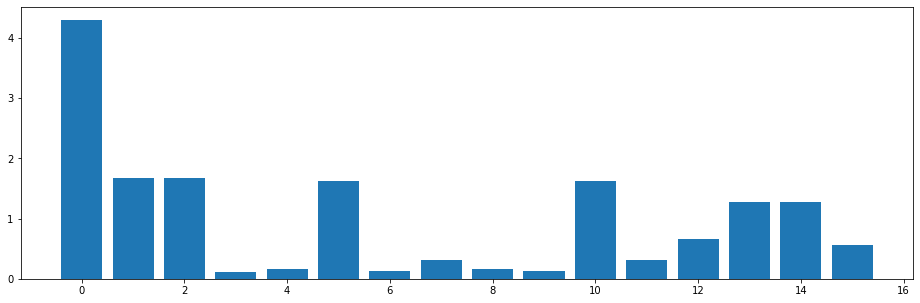

syndrome: [0 1 0 0 0]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


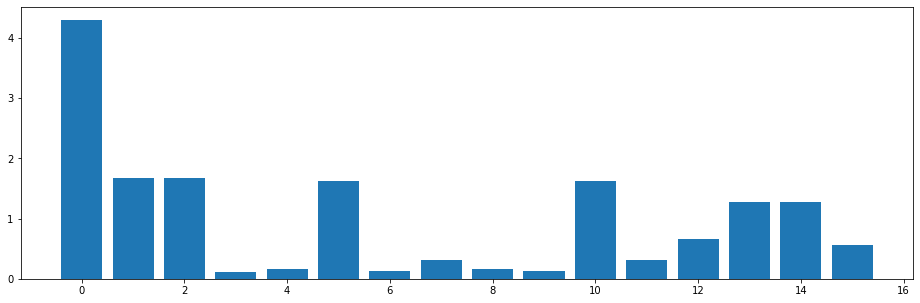

syndrome: [0 1 0 0 0]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


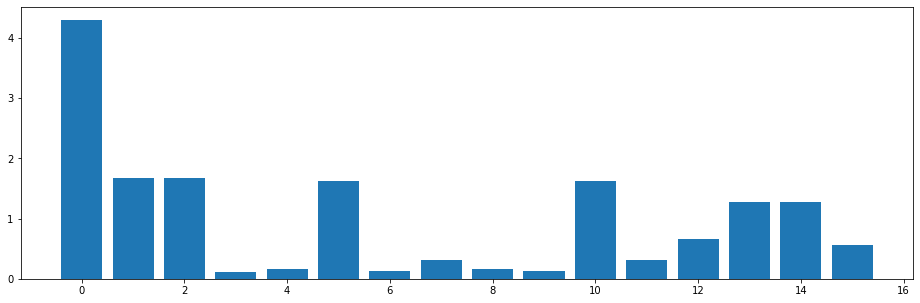

syndrome: [0 1 0 0 0]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


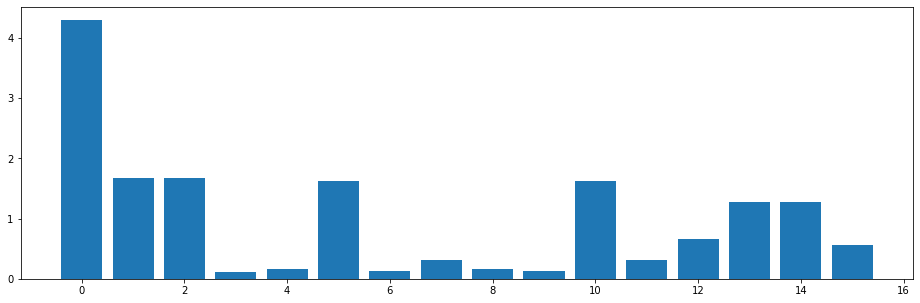

syndrome: [0 1 0 0 0]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


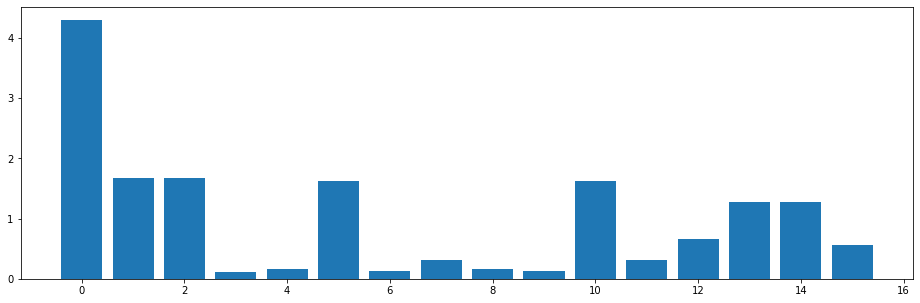

syndrome: [0 1 0 0 0]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


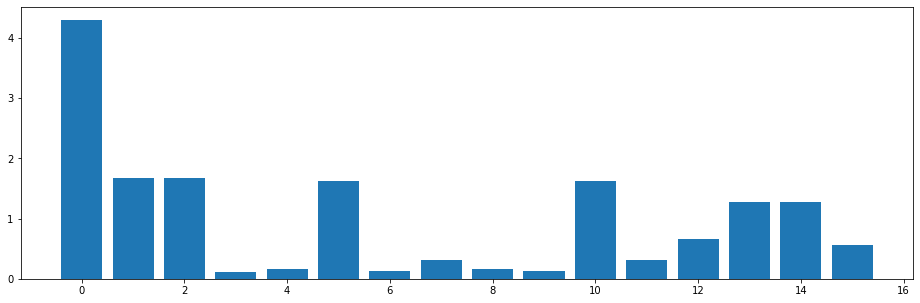

syndrome: [0 1 0 0 0]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


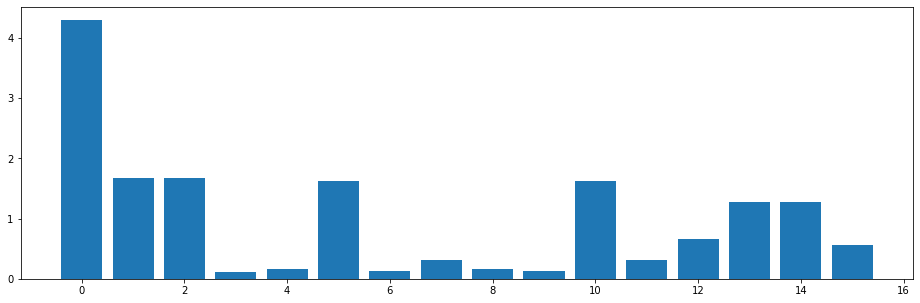

syndrome: [0 1 0 0 0]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


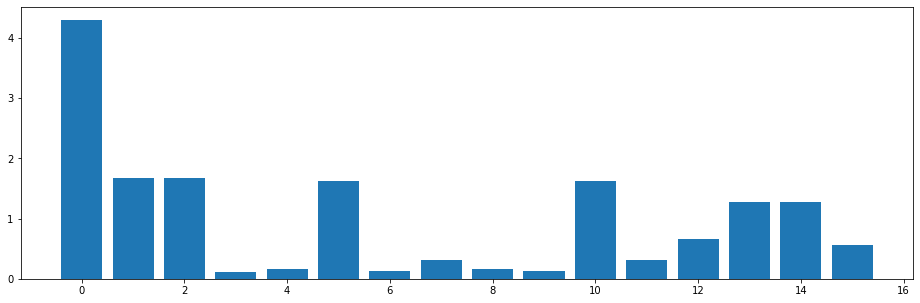

syndrome: [0 1 0 0 0]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


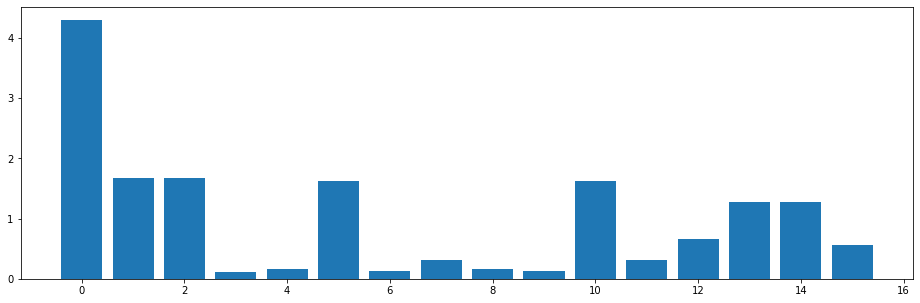

syndrome: [0 1 0 0 0]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


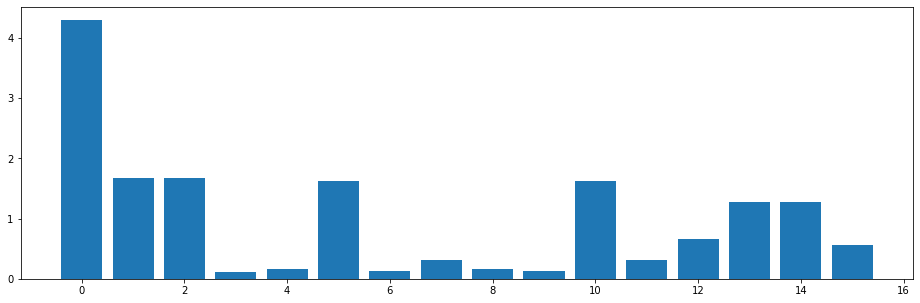

syndrome: [0 1 0 0 0]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


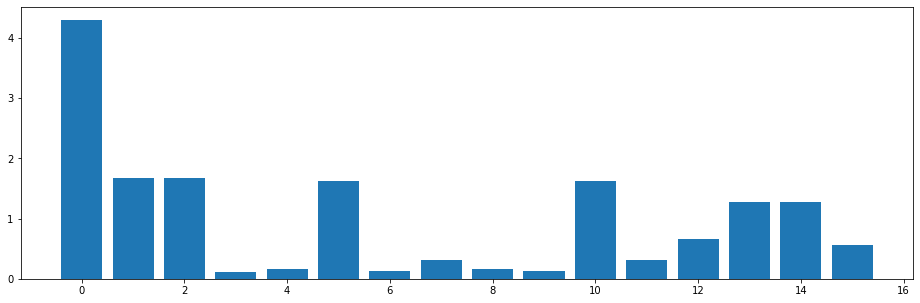

syndrome: [0 1 0 0 0]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 0, 1, 0, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 1 0 0 0]


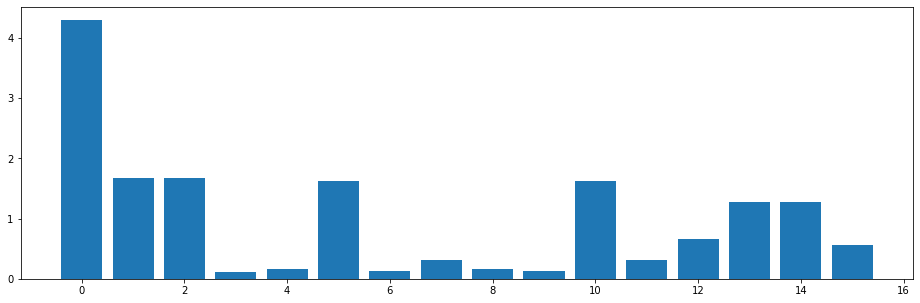

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1 0 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


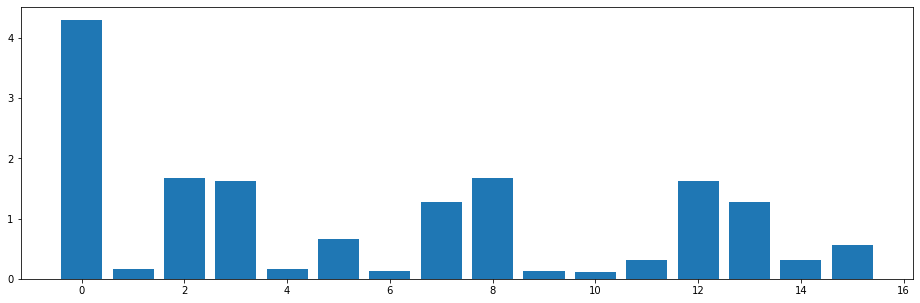

syndrome: [0 0 1 0 0]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


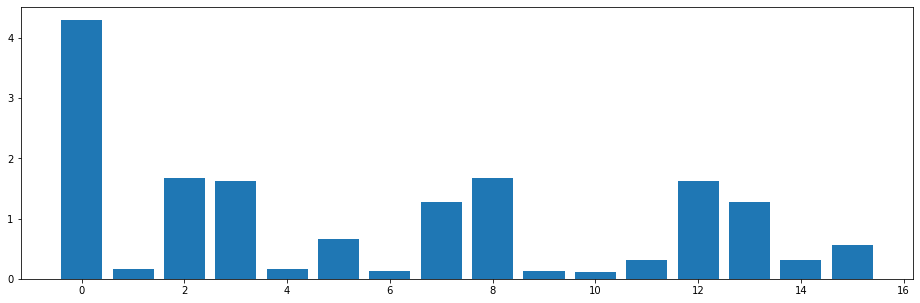

syndrome: [0 0 1 0 0]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


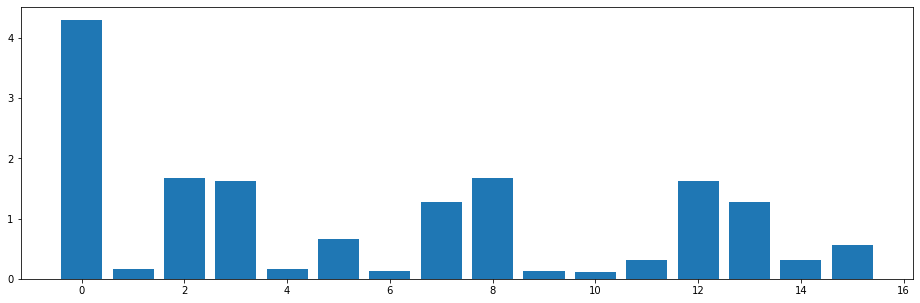

syndrome: [0 0 1 0 0]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


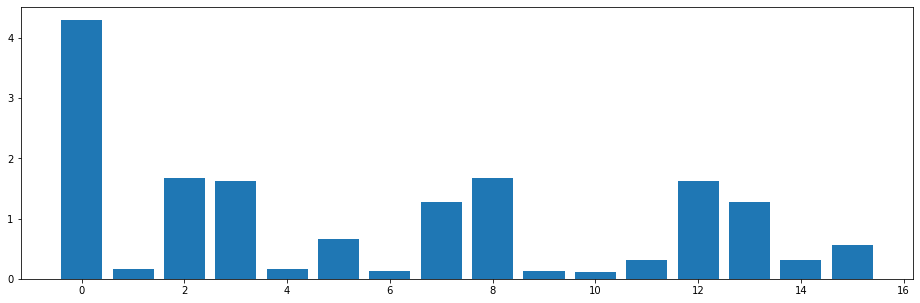

syndrome: [0 0 1 0 0]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


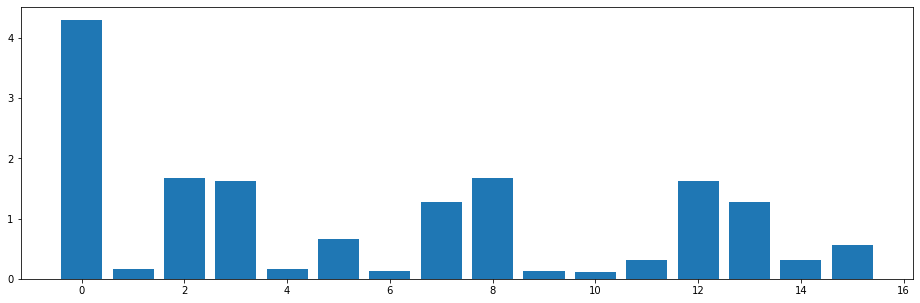

syndrome: [0 0 1 0 0]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


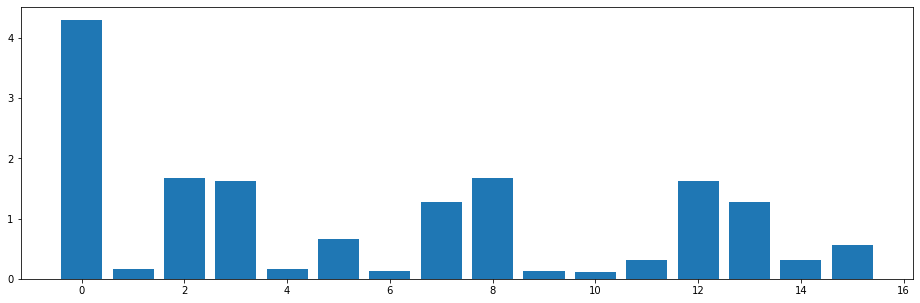

syndrome: [0 0 1 0 0]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


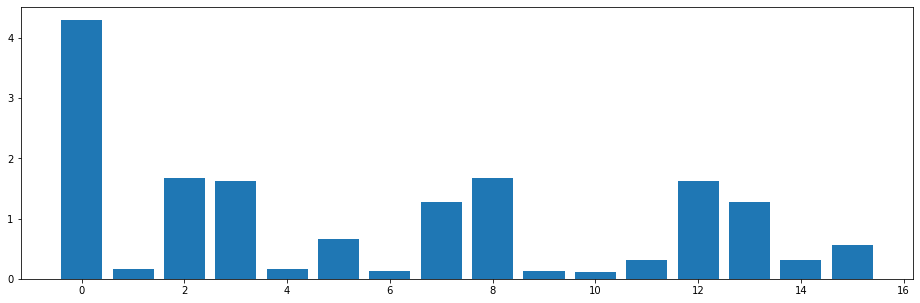

syndrome: [0 0 1 0 0]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


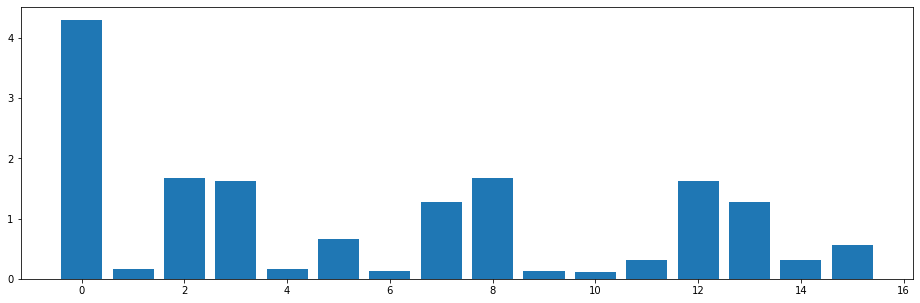

syndrome: [0 0 1 0 0]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


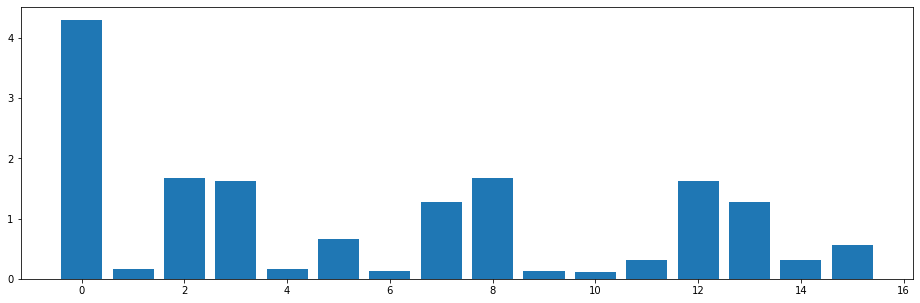

syndrome: [0 0 1 0 0]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


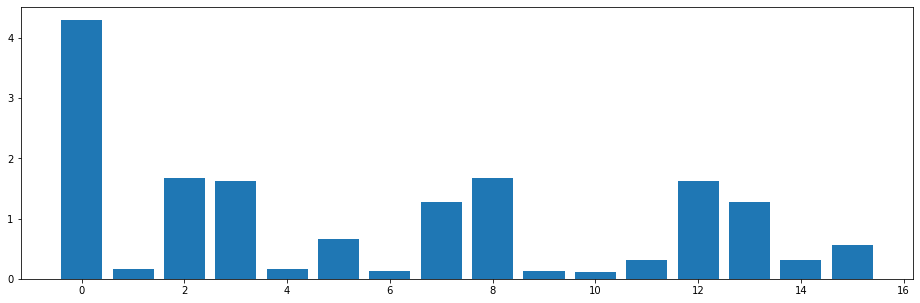

syndrome: [0 0 1 0 0]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


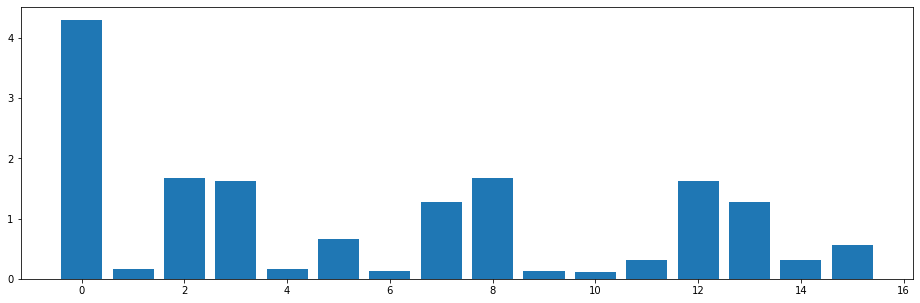

syndrome: [0 0 1 0 0]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


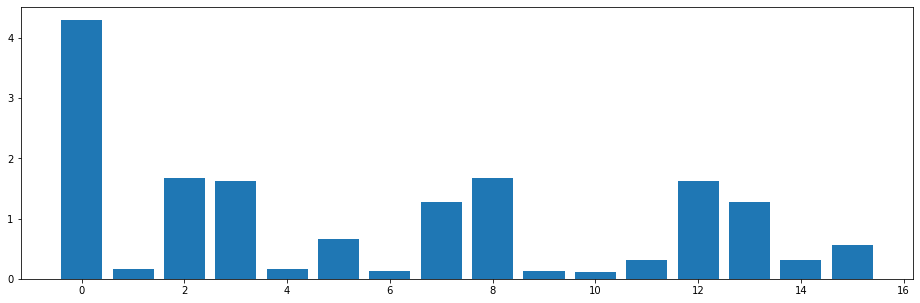

syndrome: [0 0 1 0 0]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


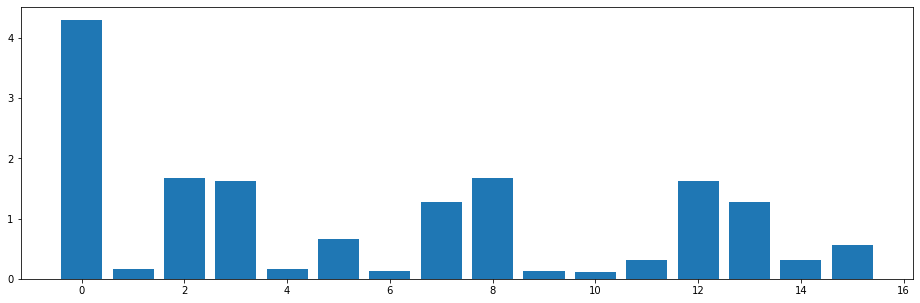

syndrome: [0 0 1 0 0]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


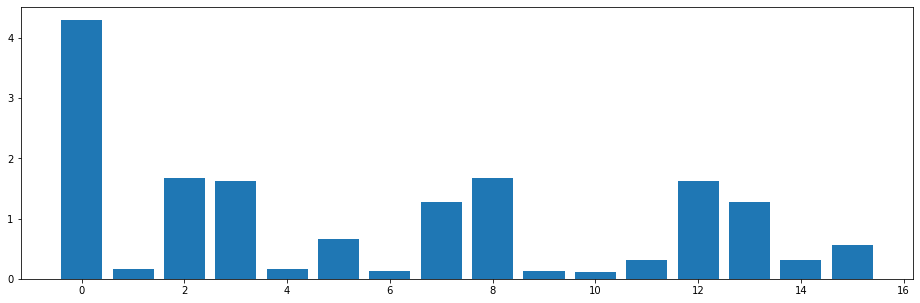

syndrome: [0 0 1 0 0]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


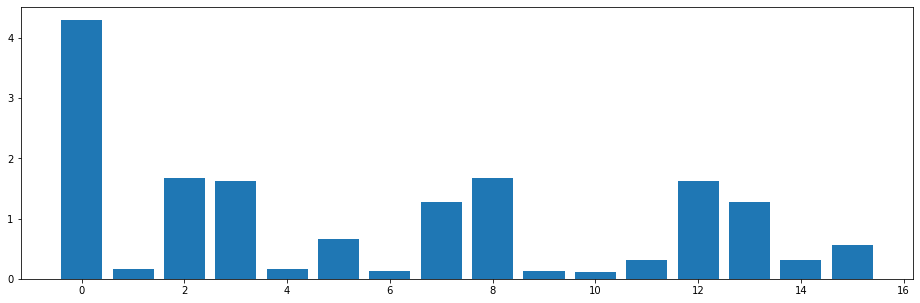

syndrome: [0 0 1 0 0]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 0, 0, 1, 0, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 1 0 0]


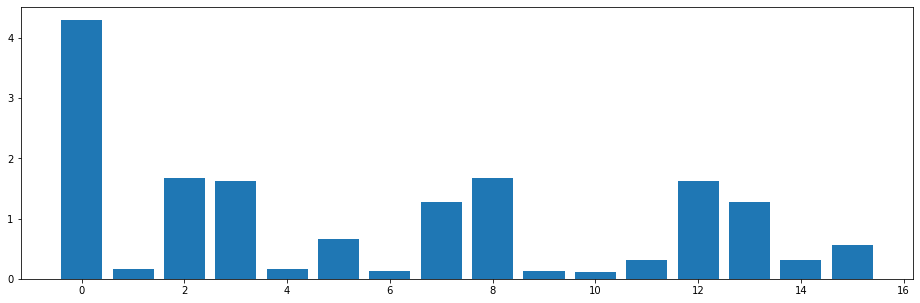

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 0 1 0]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


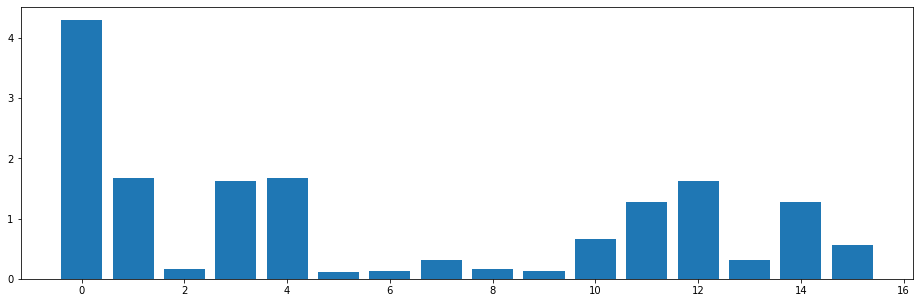

syndrome: [0 0 0 1 0]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


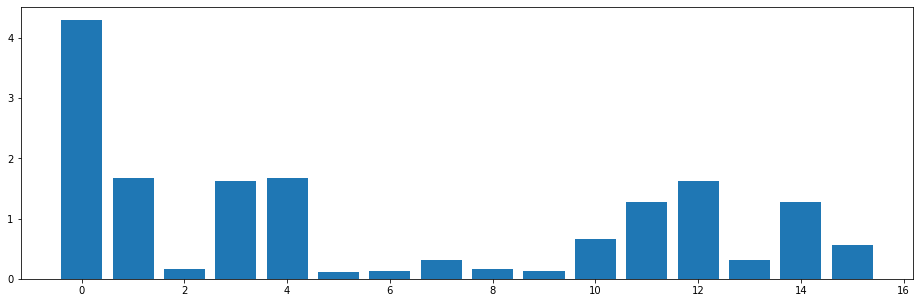

syndrome: [0 0 0 1 0]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


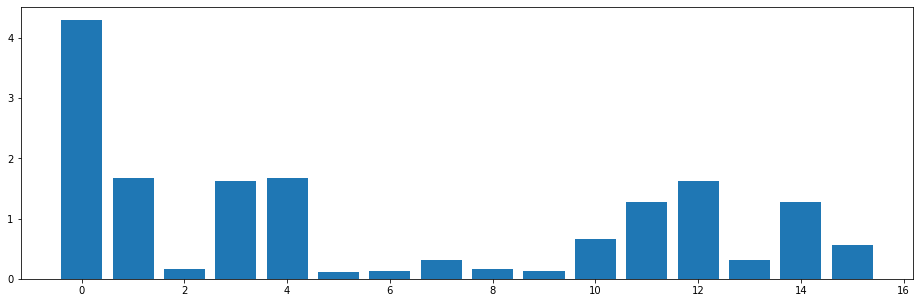

syndrome: [0 0 0 1 0]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


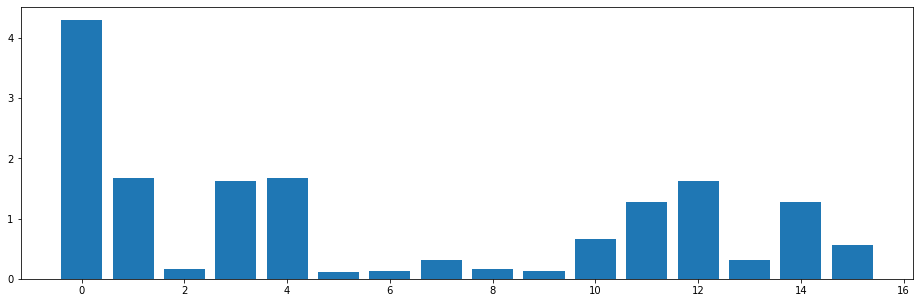

syndrome: [0 0 0 1 0]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


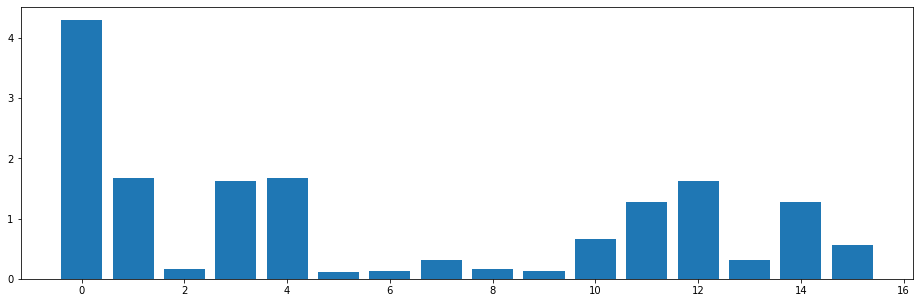

syndrome: [0 0 0 1 0]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


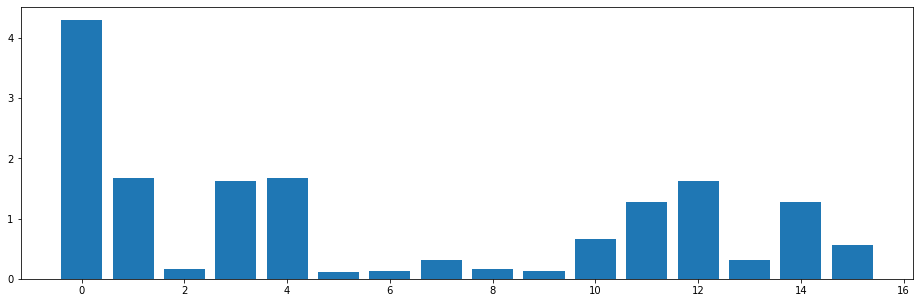

syndrome: [0 0 0 1 0]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


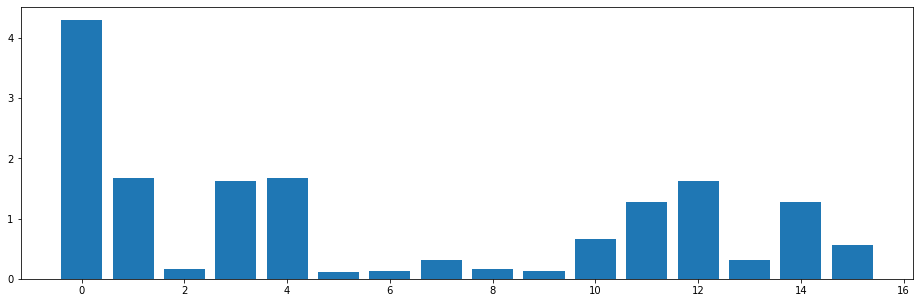

syndrome: [0 0 0 1 0]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


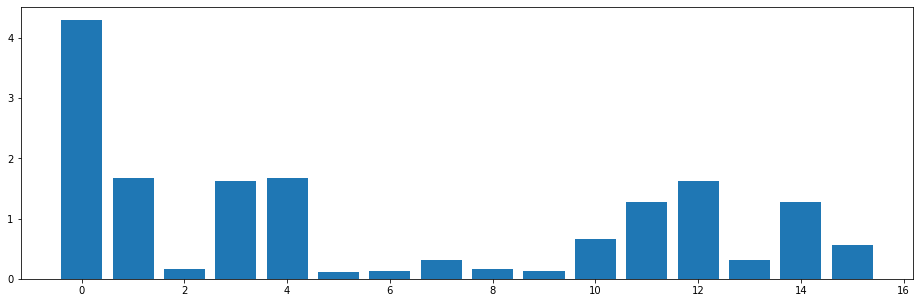

syndrome: [0 0 0 1 0]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


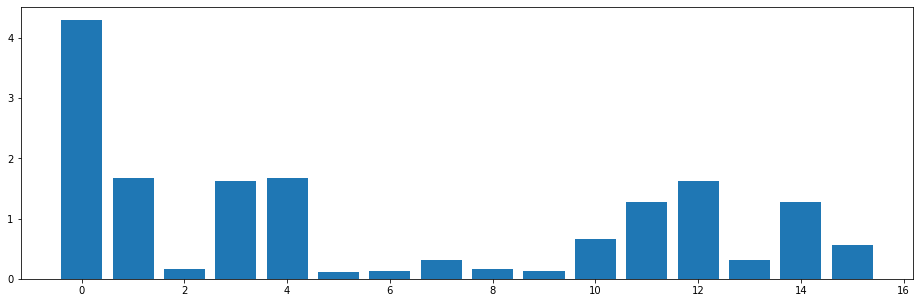

syndrome: [0 0 0 1 0]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


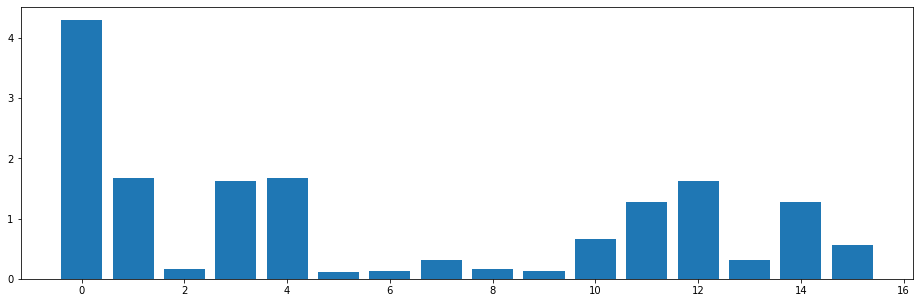

syndrome: [0 0 0 1 0]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


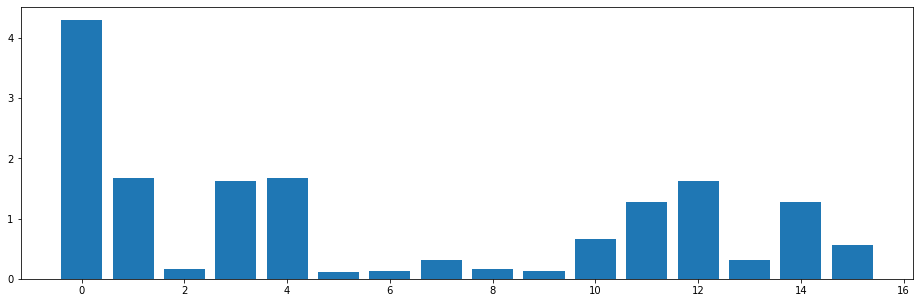

syndrome: [0 0 0 1 0]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


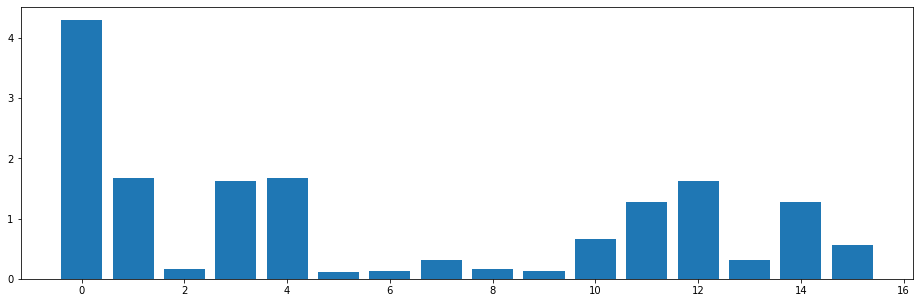

syndrome: [0 0 0 1 0]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


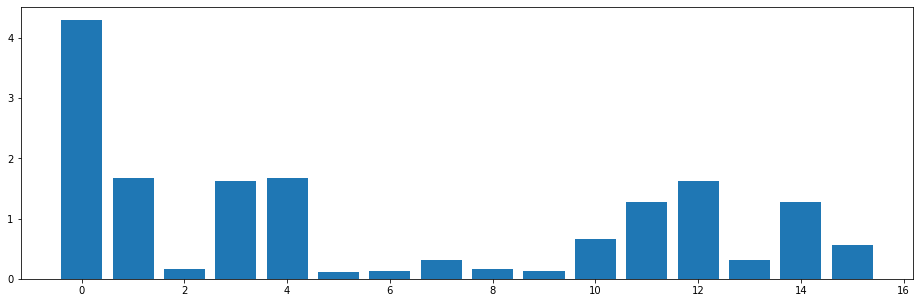

syndrome: [0 0 0 1 0]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


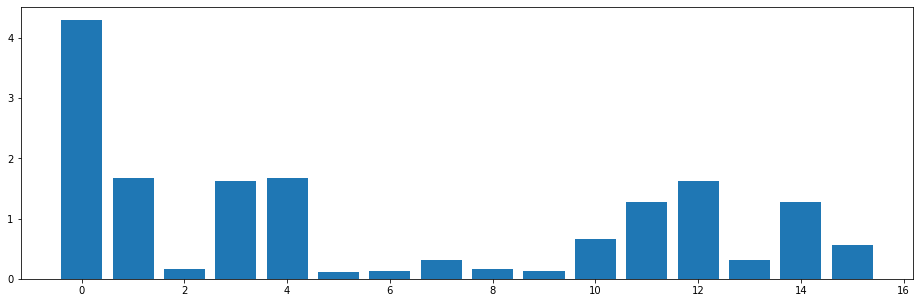

syndrome: [0 0 0 1 0]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


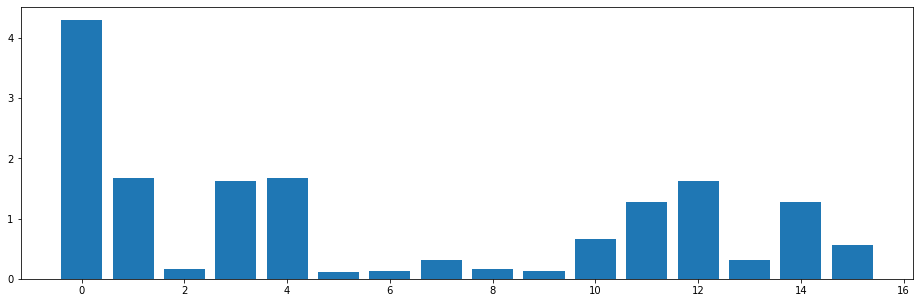

syndrome: [0 0 0 1 0]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 1, 0]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 1 0]


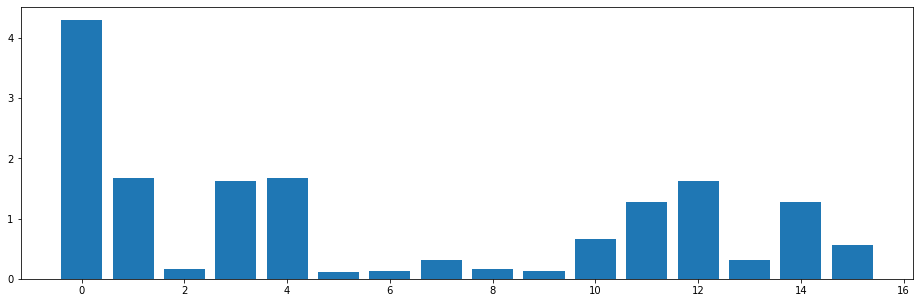

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 0 0 1]
message: [0 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


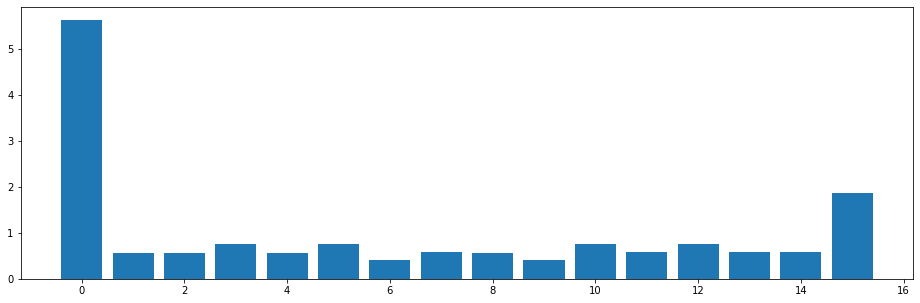

syndrome: [0 0 0 0 1]
message: [0 0 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


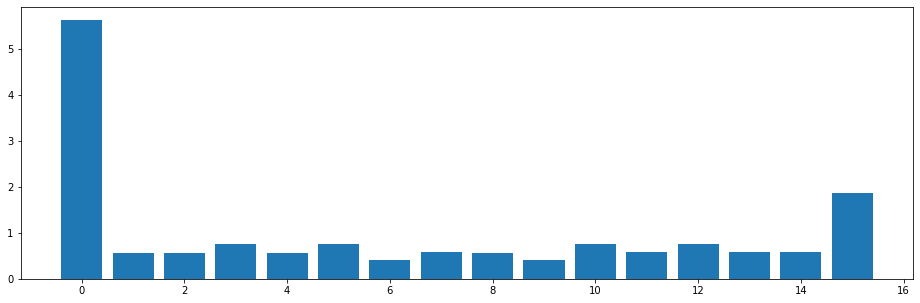

syndrome: [0 0 0 0 1]
message: [0 0 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


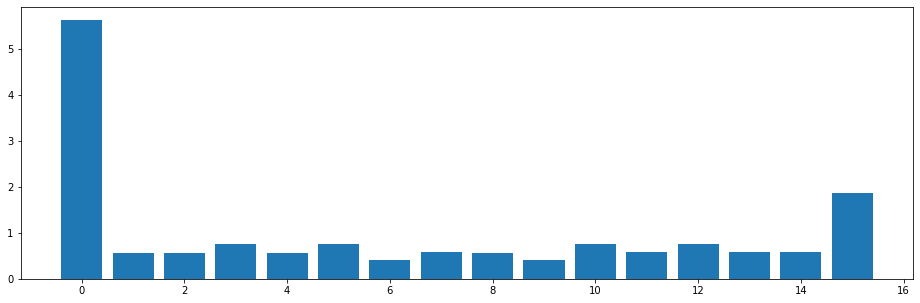

syndrome: [0 0 0 0 1]
message: [0 0 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


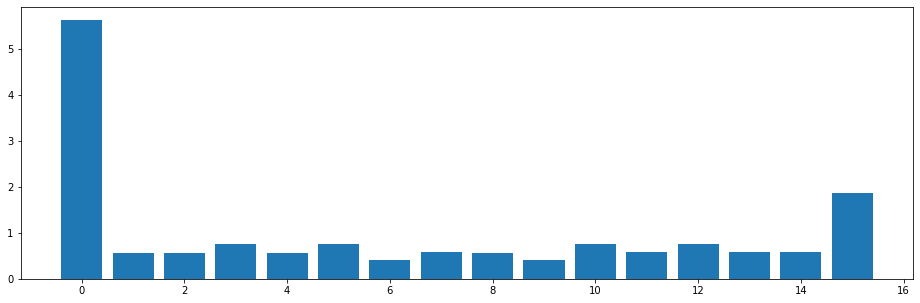

syndrome: [0 0 0 0 1]
message: [0 1 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


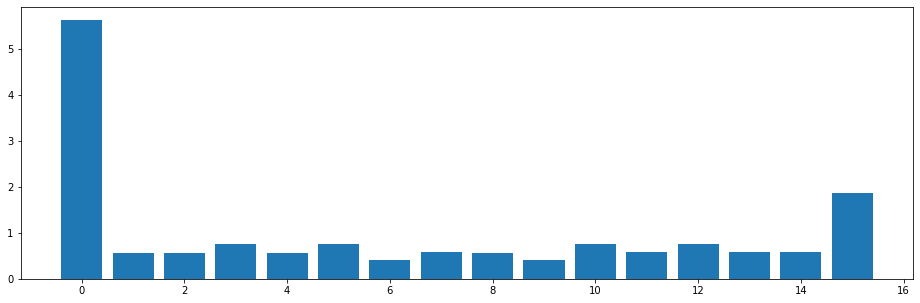

syndrome: [0 0 0 0 1]
message: [0 1 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


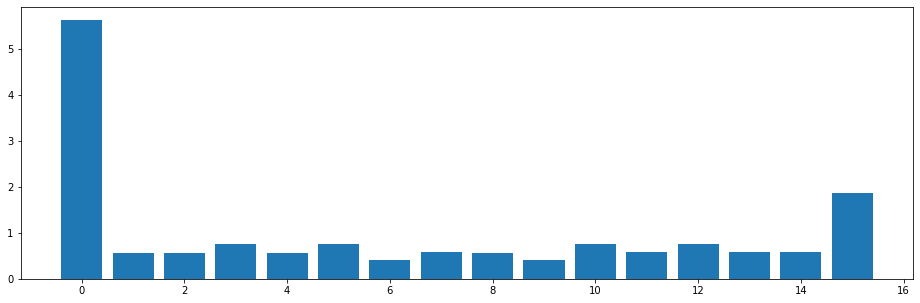

syndrome: [0 0 0 0 1]
message: [0 1 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


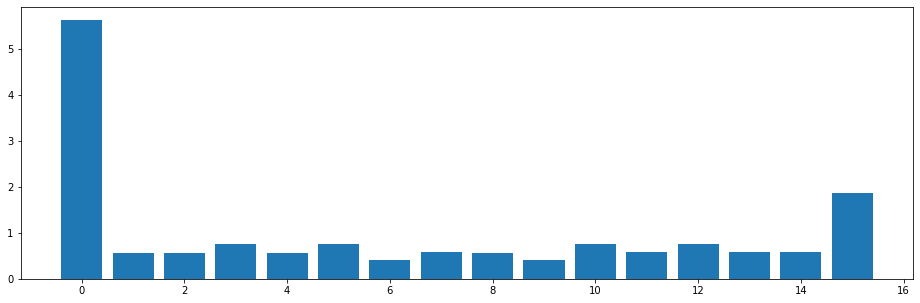

syndrome: [0 0 0 0 1]
message: [0 1 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


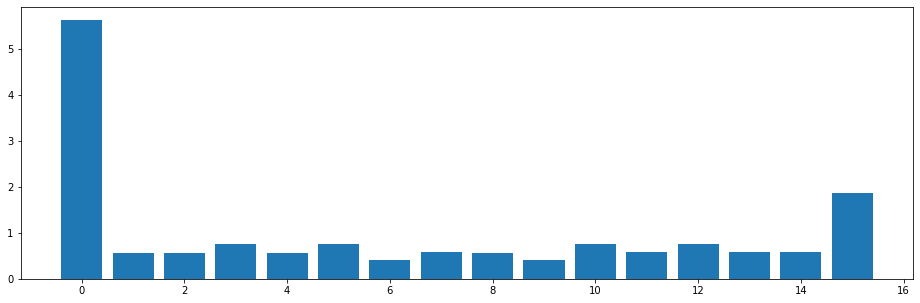

syndrome: [0 0 0 0 1]
message: [1 0 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


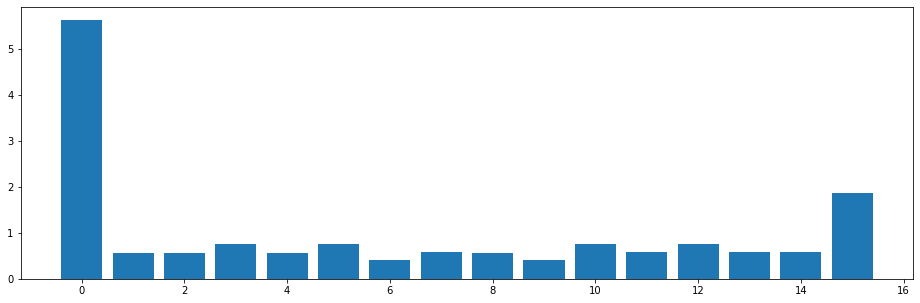

syndrome: [0 0 0 0 1]
message: [1 0 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


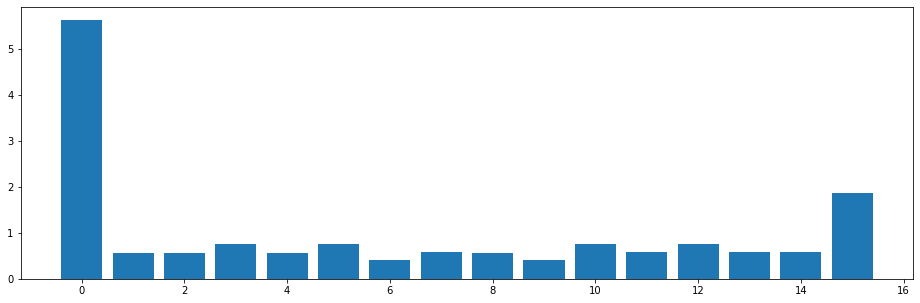

syndrome: [0 0 0 0 1]
message: [1 0 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


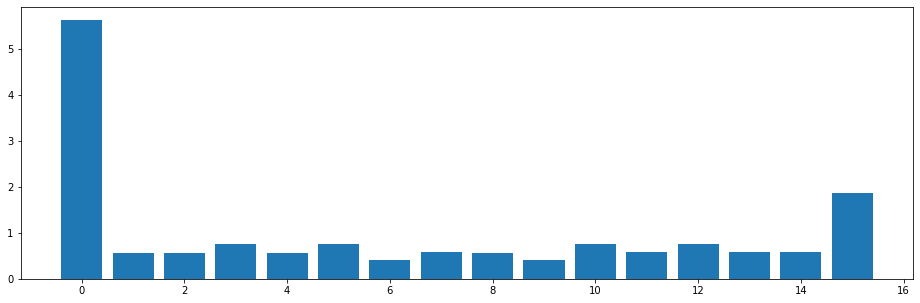

syndrome: [0 0 0 0 1]
message: [1 0 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


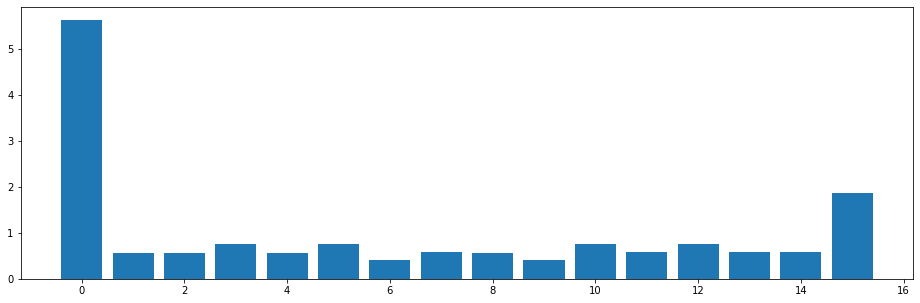

syndrome: [0 0 0 0 1]
message: [1 1 0 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


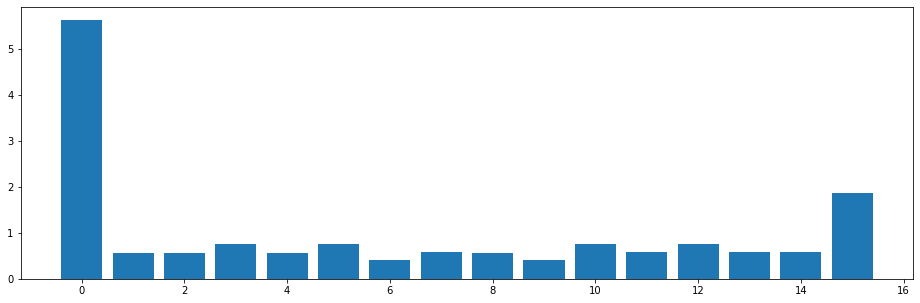

syndrome: [0 0 0 0 1]
message: [1 1 0 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


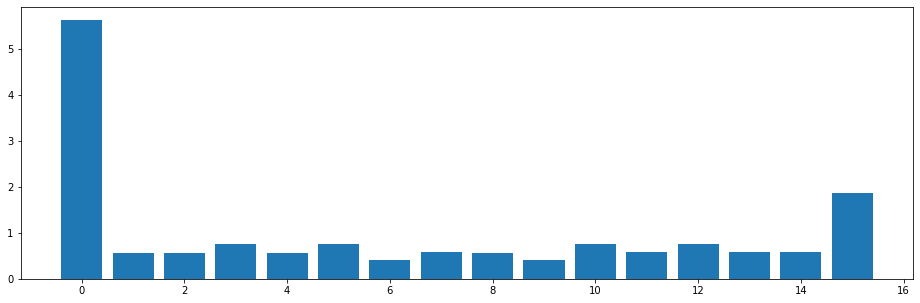

syndrome: [0 0 0 0 1]
message: [1 1 1 0]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


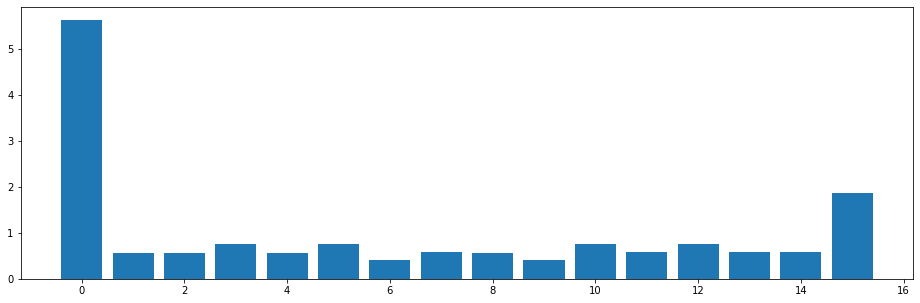

syndrome: [0 0 0 0 1]
message: [1 1 1 1]
z =  [0, 0, 0, 0, 0, 0, 0, 0, 1]
most likey basis:   0
estimate message: [0 0 0 0]
error: [0 0 0 0 0 0 0 0 1]


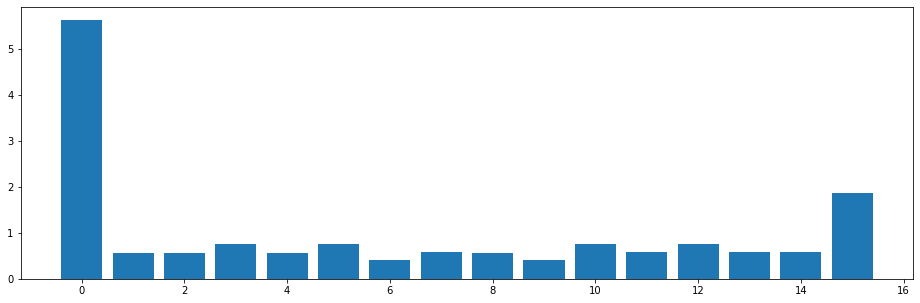

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


In [10]:
for t in range(HT.shape[0]):
    syndr = HT[t]
    n = G_oringin.shape[0]
    for k in range(2**n):
        message = basis(n)[k]
        print('syndrome:',syndr)
        print('message:',message)
        z = z_gen(syndr,H)
        print("z = ",z)
        C = sum((1-2*z[a])*Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
        B = B_generator(G_oringinT.shape[1])
        s = init_s(n)
        s_d = (s).T
        #print("the number of basis",k+1)

        #run the program
        start_time = time.time()
        step_size   = 0.05
        result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
        a_gamma         = np.arange(0, np.pi, step_size)
        a_beta          = np.arange(0, np.pi, step_size)
        #print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
        f_p_max = 0
        f_p_max_gamma = 0
        f_p_max_beta = 0
        f_psum = 0

        for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
            for j in range(0, int(3.14/step_size)+1):       # j for a_beta

                #Construct U_C
                U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
                #Construct U_B
                U_B = expm(-1j*a_beta[j]*B)


                #Construct expection of each subgraph
                state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
                state_d = (state.conjugate()).T # bra


                f_p = (state_d.dot(C)).dot(state)
                f_psum += f_p


                if f_p.real > f_p_max:
                    f_p_max = f_p.real
                    f_p_max_gamma = a_gamma[i]
                    f_p_max_beta = a_beta[j]

                result_array[i][j] = f_p.real
        #         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
        #         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
        #         print("\n Optimal gamma : ",f_p_max_gamma)
        #         print("\n Optimal beta : ",f_p_max_beta)


        end_time = time.time()
        #print("\n Runningtime : ",end_time - start_time)
        c = converter(message)
        r = np.ones(2**len(message))

        #Construct U_C
        U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
        #Construct U_B
        U_B = expm(-1j*f_p_max_beta*B)


        #Construct expection of each subgraph
        state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
        prob=[]
        for i in range(len(state)):
            p = (state[i].real)**2 + (state[i].imag)**2
            np.array(prob.append(float(p)))      
        e = np.max(prob)
        q = int(np.where(prob==np.max(prob))[0])
        print("most likey basis:  ",q)
        #     if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        #         print("CANNOT correct！！！！！！")
        #     else:
        #         print("Good Job!!!!!!")
        #         u+=1
        em= basis(n)[q]
        print('estimate message:',em)
        error = row_binary(np.array(em).dot(G_oringin)+np.array(z))
        print('error:',error)
        plt.rcParams['figure.figsize'] = [16, 5]
        plt.bar(range(0, len(state)),prob)
        plt.show()
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')